In [ ]:
"""
To make sure the fusion decomposition works
up to the part where we would stitch the sublimbs together into one limb


"""

In [1]:
from os import sys
sys.path.append("/meshAfterParty/")

In [2]:
import skeleton_utils as sk
import soma_extraction_utils as sm
import trimesh_utils as tu
import trimesh
import numpy_utils as nu
import numpy as np
from importlib import reload
import networkx as nx
import time
import compartment_utils as cu
import networkx_utils as xu
import matplotlib_utils as mu
import neuron_utils as nru

#importing at the bottom so don't get any conflicts
import itertools
from tqdm_utils import tqdm

#for meshparty preprocessing
import meshparty_skeletonize as m_sk
import general_utils as gu
import compartment_utils as cu
from meshparty import trimesh_io
from copy import deepcopy


from neuron_utils import *


# Loading the Neuron

In [3]:
import trimesh_utils as tu
curent_neuron = tu.load_mesh_no_processing("/notebooks/test_neurons/multi_soma_example.off")
segment_id = 864691136739250798
description = "multi_soma_example"

In [4]:
import neuron_visualizations as nviz
nviz.plot_objects(main_mesh=curent_neuron)

/usr/local/lib/python3.6/dist-packages/traittypes/traittypes.py:101: UserWarning: Given trait value dtype "float64" does not match required type "float64". A coerced copy has been created.
  np.dtype(self.dtype).name))


# Setting the Arguments that would be present inside a preprocessing function call

In [5]:
#predefined arguments for the Neuron constructor

decomposition_type="meshafterparty"
mesh_correspondence="meshparty" #meshafterparty_adaptive
distance_by_mesh_center=True #how the distance is calculated for mesh correspondence
meshparty_segment_size = 100
meshparty_n_surface_downsampling = 2
meshparty_adaptive_correspondence_after_creation=False
suppress_preprocessing_print=True
computed_attribute_dict=None
somas = None
branch_skeleton_data=None
combine_close_skeleton_nodes = True
combine_close_skeleton_nodes_threshold=700
ignore_warnings=True
suppress_output=False
calculate_spines=True
widths_to_calculate=["no_spine_median_mesh_center",
                "no_spine_mean_mesh_center"]
fill_hole_size=2000

In [105]:
import trimesh_utils as tu

In [ ]:
tu.load_mesh_no_processing

In [6]:
#arguments for the preprocess neuron
mesh = curent_neuron
segment_id=segment_id
description=description

sig_th_initial_split=15 #for significant splitting meshes in the intial mesh split
limb_threshold = 2000 #the mesh faces threshold for a mesh to be qualified as a limb (otherwise too small)
filter_end_node_length=4001 #used in cleaning the skeleton during skeletonizations
return_no_somas = False

decomposition_type=decomposition_type
mesh_correspondence=mesh_correspondence
distance_by_mesh_center=distance_by_mesh_center
meshparty_segment_size =meshparty_segment_size
meshparty_n_surface_downsampling = meshparty_n_surface_downsampling
somas=somas
branch_skeleton_data=branch_skeleton_data
combine_close_skeleton_nodes = combine_close_skeleton_nodes
combine_close_skeleton_nodes_threshold=combine_close_skeleton_nodes_threshold

# Setting up the metadata

In [7]:
whole_processing_tiempo = time.time()


"""
Purpose: To process the mesh into a format that can be loaded into the neuron class
and used for higher order processing (how to visualize is included)

"""
if description is None:
    description = "no_description"
if segment_id is None:
    #pick a random segment id
    segment_id = np.random.randint(100000000)
    print(f"picking a random 7 digit segment id: {segment_id}")
    description += "_random_id"


if mesh is None:
    if current_mesh_file is None:
        raise Exception("No mesh or mesh_file file were given")
    else:
        current_neuron = trimesh.load_mesh(current_mesh_file)
else:
    current_neuron = mesh

# ************************ Phase A: Soma and Limb Identification ********************************

In [8]:
# --- 1) Doing the soma detection
if somas is None:
    soma_mesh_list,run_time,total_soma_list_sdf = sm.extract_soma_center(segment_id,
                                             current_neuron.vertices,
                                             current_neuron.faces)
else:
    soma_mesh_list,run_time,total_soma_list_sdf = somas

# geting the soma centers
if len(soma_mesh_list) <= 0:
    print(f"**** No Somas Found for Mesh {segment_id} so just one mesh")
    soma_mesh_list_centers = []
    if return_no_somas:
        return_value= soma_mesh_list_centers
    raise Exception("Processing of No Somas is not yet implemented yet")
else:
    #compute the soma centers
    print(f"Soma List = {soma_mesh_list}")

    soma_mesh_list_centers = sm.find_soma_centroids(soma_mesh_list)
    print(f"soma_mesh_list_centers = {soma_mesh_list_centers}")

Current Arguments Using (adjusted for decimation):
 large_mesh_threshold= 15000.0 
large_mesh_threshold_inner = 10000.0 
soma_size_threshold = 937.5 
soma_size_threshold_max = 12000.0
outer_decimation_ratio = 0.25
inner_decimation_ratio = 0.25
xvfb-run -n 7903 -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Platinum_Decomp_Fusion/current_running/864691136739250798/neuron_864691136739250798.off -o /notebooks/Platinum_Decomp_Fusion/current_running/864691136739250798/neuron_864691136739250798_decimated.off -s /notebooks/Platinum_Decomp_Fusion/current_running/864691136739250798/decimation_meshlab_25124549.mls
Total found significant pieces before Poisson = [<trimesh.Trimesh(vertices.shape=(139795, 3), faces.shape=(284336, 3))>]
----- working on large mesh #0: <trimesh.Trimesh(vertices.shape=(139795, 3), faces.shape=(284336, 3))>
pre_largest_mesh_path = /notebooks/Platinum_Decomp_Fusion/current_running/864691136739250798/neuron_864691136739250798_decimated_largest_piece.off
xvfb-r

removed temporary input file: /notebooks/Platinum_Decomp_Fusion/current_running/Poisson_temp/neuron_597153.off
removed temporary output file: /notebooks/Platinum_Decomp_Fusion/current_running/Poisson_temp/neuron_597153_poisson.off
mesh.is_watertight = True
/notebooks/Platinum_Decomp_Fusion/current_running/Poisson_temp/poisson_827962.mls is being deleted....
Inside sphere validater: ratio_val = 2.8024670385084693



 Total time for run = 118.80016374588013
Before Filtering the number of somas found = 2
Performing Soma Mesh Backtracking to original mesh
# total split meshes = 27
viable_meshes = [0]
There were 26 pieces found after size threshold
# of soma containing seperate meshes = 1
meshes with somas = {0: [0]}


----Working on soma-containing mesh piece 0----
current_soma_mesh_list = [<trimesh.Trimesh(vertices.shape=(3065, 3), faces.shape=(6001, 3))>]
current_mesh = <trimesh.Trimesh(vertices.shape=(139795, 3), faces.shape=(284334, 3))>

inside Soma subtraction
mesh pieces in subtact 

In [9]:
#--- Phase 2: getting the soma submeshes that are connected to each soma and identifiying those that aren't 
# ------------------ (and eliminating any mesh pieces inside the soma) ------------------------

main_mesh_total = current_neuron


#finding the mesh pieces that contain the soma
#splitting the current neuron into distinct pieces
split_meshes = tu.split_significant_pieces(
                            main_mesh_total,
                            significance_threshold=sig_th_initial_split,
                            print_flag=False)

print(f"# total split meshes = {len(split_meshes)}")


#returns the index of the split_meshes index that contains each soma    
containing_mesh_indices = sm.find_soma_centroid_containing_meshes(soma_mesh_list,
                                        split_meshes)

# filtering away any of the inside floating pieces: 
non_soma_touching_meshes = [m for i,m in enumerate(split_meshes)
                 if i not in list(containing_mesh_indices.values())]


#Adding the step that will filter away any pieces that are inside the soma
if len(non_soma_touching_meshes) > 0 and len(soma_mesh_list) > 0:
    """
    *** want to save these pieces that are inside of the soma***
    """

    non_soma_touching_meshes,inside_pieces = sm.filter_away_inside_soma_pieces(soma_mesh_list,non_soma_touching_meshes,
                                    significance_threshold=sig_th_initial_split,
                                    return_inside_pieces = True)                                                      


split_meshes # the meshes of the original mesh
containing_mesh_indices #the mapping of each soma centroid to the correct split mesh
soma_containing_meshes = sm.grouping_containing_mesh_indices(containing_mesh_indices)

soma_touching_meshes = [split_meshes[k] for k in soma_containing_meshes.keys()]


#     print(f"# of non soma touching seperate meshes = {len(non_soma_touching_meshes)}")
#     print(f"# of inside pieces = {len(inside_pieces)}")
print(f"# of soma containing seperate meshes = {len(soma_touching_meshes)}")
print(f"meshes with somas = {soma_containing_meshes}")






# total split meshes = 79
There were 78 pieces found after size threshold
# of soma containing seperate meshes = 1
meshes with somas = {0: [0, 1]}


In [10]:
tu = reload(tu)
#--- 3)  Soma Extraction was great (but it wasn't the original soma faces), so now need to get the original soma faces and the original non-soma faces of original pieces

"""
for each soma touching mesh get the following:
1) original soma meshes
2) significant mesh pieces touching these somas
3) The soma connectivity to each of the significant mesh pieces
-- later will just translate the 


Process: 

1) Final all soma faces (through soma extraction and then soma original faces function)
2) Subtact all soma faces from original mesh
3) Find all significant mesh pieces
4) Backtrack significant mesh pieces to orignal mesh and find connectivity of each to all
   the available somas
Conclusion: Will have connectivity map


"""

soma_touching_mesh_data = dict()

for z,(mesh_idx, soma_idxes) in enumerate(soma_containing_meshes.items()):
    soma_touching_mesh_data[z] = dict()
    print(f"\n\n----Working on soma-containing mesh piece {z}----")

    #1) Final all soma faces (through soma extraction and then soma original faces function)
    current_mesh = split_meshes[mesh_idx]

    current_soma_mesh_list = [soma_mesh_list[k] for k in soma_idxes]

    current_time = time.time()
    mesh_pieces_without_soma = sm.subtract_soma(current_soma_mesh_list,current_mesh,
                                                significance_threshold=250)
    print(f"Total time for Subtract Soam = {time.time() - current_time}")
    current_time = time.time()

    mesh_pieces_without_soma_stacked = tu.combine_meshes(mesh_pieces_without_soma)

    # find the original soma faces of mesh
    soma_faces = tu.original_mesh_faces_map(current_mesh,mesh_pieces_without_soma_stacked,matching=False)
    print(f"Total time for Original_mesh_faces_map for mesh_pieces without soma= {time.time() - current_time}")
    current_time = time.time()
    soma_meshes = current_mesh.submesh([soma_faces],append=True,repair=False)

    # finding the non-soma original faces
    non_soma_faces = tu.original_mesh_faces_map(current_mesh,soma_meshes,matching=False)
    non_soma_stacked_mesh = current_mesh.submesh([non_soma_faces],append=True,repair=False)

    print(f"Total time for Original_mesh_faces_map for somas= {time.time() - current_time}")
    current_time = time.time()

    # 3) Find all significant mesh pieces
    sig_non_soma_pieces,insignificant_limbs = tu.split_significant_pieces(non_soma_stacked_mesh,significance_threshold=limb_threshold,
                                                     return_insignificant_pieces=True)

    print(f"Total time for sig_non_soma_pieces= {time.time() - current_time}")
    current_time = time.time()

    soma_touching_mesh_data[z]["branch_meshes"] = sig_non_soma_pieces

    #4) Backtrack significant mesh pieces to orignal mesh and find connectivity of each to all the available somas
    # get all the seperate mesh faces

    #How to seperate the mesh faces
    seperate_soma_meshes,soma_face_components = tu.split(soma_meshes,only_watertight=False)
    #take the top largest ones depending how many were originally in the soma list
    seperate_soma_meshes = seperate_soma_meshes[:len(soma_mesh_list)]
    soma_face_components = soma_face_components[:len(soma_mesh_list)]

    soma_touching_mesh_data[z]["soma_meshes"] = seperate_soma_meshes

    print(f"Total time for split= {time.time() - current_time}")
    current_time = time.time()



    soma_to_piece_connectivity = dict()
    soma_to_piece_touching_vertices = dict()
    soma_to_piece_touching_vertices_idx = dict()
    limb_root_nodes = dict()
    
    m_vert_graph = tu.mesh_vertex_graph(current_mesh)
    
    for i,curr_soma in enumerate(seperate_soma_meshes):
        (connected_mesh_pieces,
         connected_mesh_pieces_vertices,
         connected_mesh_pieces_vertices_idx) = tu.mesh_pieces_connectivity(
                        main_mesh=current_mesh,
                        central_piece=curr_soma,
                        periphery_pieces = sig_non_soma_pieces,
                        return_vertices = True,
                        return_vertices_idx=True)
        #print(f"soma {i}: connected_mesh_pieces = {connected_mesh_pieces}")
        soma_to_piece_connectivity[i] = connected_mesh_pieces

        soma_to_piece_touching_vertices[i] = dict()
        for piece_index,piece_idx in enumerate(connected_mesh_pieces):
            limb_root_nodes[piece_idx] = connected_mesh_pieces_vertices[piece_index][0]
            
            """ Old way of finding vertex connected components on a mesh without trimesh function
            #find the number of touching groups and save those 
            soma_touching_graph = m_vert_graph.subgraph(connected_mesh_pieces_vertices_idx[piece_index])
            soma_con_comp = [current_mesh.vertices[np.array(list(k)).astype("int")] for k in list(nx.connected_components(soma_touching_graph))]
            soma_to_piece_touching_vertices[i][piece_idx] = soma_con_comp
            """
            
            soma_to_piece_touching_vertices[i][piece_idx] = tu.split_vertex_list_into_connected_components(
                                                vertex_indices_list=connected_mesh_pieces_vertices_idx[piece_index],
                                                mesh=current_mesh, 
                                                vertex_graph=m_vert_graph, 
                                                return_coordinates=True
                                               )
            
            
            
            

#         border_debug = False
#         if border_debug:
#             print(f"soma_to_piece_connectivity = {soma_to_piece_connectivity}")
#             print(f"soma_to_piece_touching_vertices = {soma_to_piece_touching_vertices}")


    print(f"Total time for mesh_pieces_connectivity= {time.time() - current_time}")

    soma_touching_mesh_data[z]["soma_to_piece_connectivity"] = soma_to_piece_connectivity

print(f"# of insignificant_limbs = {len(insignificant_limbs)} with trimesh : {insignificant_limbs}")



# Lets have an alert if there was more than one soma disconnected meshes
if len(soma_touching_mesh_data.keys()) > 1:
    raise Exception("More than 1 disconnected meshes that contain somas")

current_mesh_data = soma_touching_mesh_data
soma_containing_idx = 0

#doing inversion of the connectivity and touching vertices
piece_to_soma_touching_vertices = gu.flip_key_orders_for_dict(soma_to_piece_touching_vertices)


# ****Soma Touching mesh Data has the branches and the connectivity (So this is where you end up skipping if you don't have somas)***



----Working on soma-containing mesh piece 0----

inside Soma subtraction
mesh pieces in subtact soma BEFORE the filtering inside pieces = [<trimesh.Trimesh(vertices.shape=(153780, 3), faces.shape=(308589, 3))>, <trimesh.Trimesh(vertices.shape=(87518, 3), faces.shape=(175900, 3))>, <trimesh.Trimesh(vertices.shape=(58482, 3), faces.shape=(117235, 3))>, <trimesh.Trimesh(vertices.shape=(56775, 3), faces.shape=(114294, 3))>, <trimesh.Trimesh(vertices.shape=(54856, 3), faces.shape=(109933, 3))>, <trimesh.Trimesh(vertices.shape=(51741, 3), faces.shape=(103848, 3))>, <trimesh.Trimesh(vertices.shape=(29266, 3), faces.shape=(58666, 3))>, <trimesh.Trimesh(vertices.shape=(29129, 3), faces.shape=(58497, 3))>, <trimesh.Trimesh(vertices.shape=(14705, 3), faces.shape=(29558, 3))>, <trimesh.Trimesh(vertices.shape=(1132, 3), faces.shape=(2218, 3))>]
There were 10 pieces found after size threshold
mesh pieces in subtact soma AFTER the filtering inside pieces = [<trimesh.Trimesh(vertices.shape=(153780, 

/meshAfterParty/trimesh_utils.py:318: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  ordered_comp_indices = np.array([k.astype("int") for k in ordered_components])


Total time for mesh_pieces_connectivity= 34.024970054626465
# of insignificant_limbs = 0 with trimesh : []


# Process that will start for each limb

In [186]:
sk = reload(sk)
tu = reload(tu)
cu = reload(cu)
m_sk = reload(m_sk)
pre = reload(pre)
xu = reload(xu)
nu = reload(nu)
gu = reload(gu)


proper_time = time.time()

#The containers that will hold the final data for the preprocessed neuron
limb_correspondence=dict()
limb_network_stating_info = dict()

# ---------- Part A: skeletonization and mesh decomposition --------- #
skeleton_time = time.time()

for curr_limb_idx,limb_mesh_mparty in enumerate(current_mesh_data[0]["branch_meshes"]):
    
    #Arguments to pass to the specific function (when working with a limb)
    soma_touching_vertices_dict = piece_to_soma_touching_vertices[curr_limb_idx]
    
#     if curr_limb_idx != 10:
#         continue
    
    curr_limb_time = time.time()
    print(f"\n\n----- Working on Proper Limb # {curr_limb_idx} ---------")
    

    limb_correspondence_individual,network_starting_info = pre.preprocess_limb(mesh=limb_mesh_mparty,
                   soma_touching_vertices_dict = soma_touching_vertices_dict,
                   return_concept_network = False, 
                   return_concept_network_starting_info=True,
                   width_threshold_MAP=500,
                   size_threshold_MAP=2000,
                   surface_reconstruction_size=1000,  
                    
                   #arguments added from the big preprocessing step                                                            
                   distance_by_mesh_center=distance_by_mesh_center,
                   meshparty_segment_size=meshparty_segment_size,
                   meshparty_n_surface_downsampling = meshparty_n_surface_downsampling,
                                                                               
                   )
    #Storing all of the data to be sent to 
    
    limb_correspondence[curr_limb_idx] = limb_correspondence_individual
    limb_network_stating_info[curr_limb_idx] = network_starting_info
    




----- Working on Proper Limb # 0 ---------
Time for preparing soma vertices and root: 1.2874603271484375e-05
cc_vertex_thresh = 10


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:03<00:00,  3.43s/it]

Time for 1st pass MP skeletonization: 4.840956449508667
branches_touching_root = [60]
length of Graph = 15718
Working on path [7923. 7950. 7993. 8001.]
path_degrees = [3, 2, 2, 3]
max(kept_branches_idx) = 60, len(kept_branches_idx) = 60
empty_indices % = 0.0
 conflict_indices % = 0.01305300270911377



AFTER face_lookup_resolved_test



Decomposing first pass: 9.629514455795288
Attempting to use MeshAfterParty Skeletonization and Mesh Correspondence
Another print
Found len(mesh_large_idx) MAP candidates: [15751, 1759, 9026, 4401, 5622, 2386, 2953, 1989, 2291, 4960, 11551, 11104, 7852, 15937, 4547, 10085, 15272, 663, 220, 7938, 998, 2612, 12829, 885, 8845, 11437, 11077, 4673, 2776, 2612, 9875, 2453, 2258, 7366, 10484, 12960, 15416, 16049, 3960]
mesh_large_connectivity: 1.910592794418335
Finding MAP candidates connected components: 0.0004315376281738281
len(filtered_pieces) = 2
skeleton_connectivity_MP : 0.2567787170410156
Grouping MP Sublimbs by Graph: 0.0348353385925293
Divinding into MP and MAP pieces: 9.5367431640625e-07
--- Working on MAP piece 0---
MAP Filtering Soma Pieces: 0.018421173095703125
inside skeletonize_connected_branch and use_surface_after_CGAL=False, surface_reconstruction_size=1000
     Starting Screened Poisson
xvfb-run -n 8078 -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Platinum_Dec


No skeletons to stack so returning empty list
len_subgraphs AT BEGINNING of the loop


all graph is one component!

Total time for skeleton stitching = 0.09520125389099121
The process was using a temp folder
Checking connected components after skeletonize_connected_branch
    Total time for skeletonizing branch: 88.20790791511536
Checking connected components after removing cycles
Total time for mesh KDTree = 1.6915414333343506
sbv[0].reshape(-1,3) = [[755103.1 950459.4 872527.1]]
closest_sk_pt_coord BEFORE = [757054. 949842. 873811.]
current_skeleton.shape = (2606, 2, 3)
Current stitch point was a branch or endpoint
change_status for create soma extending pieces = False
closest_sk_pt_coord AFTER = [757054. 949842. 873811.]
skipping soma 0 because closest skeleton node was already end node
endpoints_must_keep = {0: array([[757054., 949842., 873811.]])}
    Total time for Fixing Skeleton Soma Endpoint Extension : 2.684032678604126
filter_end_node_length = 4001
Using Distance measure skeletal_distance
endpoints_must_keep = [[757054. 949842. 873811.]]
Number of end_nodes BE


Checking connected components after clean_skeleton
after DISTANCE cleaning limb size of skeleton = (2246, 2, 3)
********COMBINING CLOSE SKELETON NODES WITHIN 700 DISTANCE**********
Found 0 valid paths to replace
valid_paths = []
valid_path_lengths = []
No valid paths found so just returning the original
skeletonize_and_clean_connected_branch_CGAL: 98.3445131778717
Working on limb correspondence for #0 MAP piece



Total time for decomposition = 49.425962924957275
mesh_correspondence_first_pass: 49.42599272727966
Limb decomposed into 25 branches
divided_skeleton_graph_recovered = (2246, 2, 3) and 
current_mesh_data[0]['branch_skeletons_cleaned'].shape = (2246, 2, 3)

Number of connected components in deocmposed recovered graph = 1
Number of connected components in cleaned skeleton graph= 1
The downsampled branches number of connected components = 1
Empty submeshes = []


--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (24, 25)
empty_indices % = 0.04638913987262269
 conflict_indices % = 0.029060243441978682



AFTER face_lookup_resolved_test
Took 0 iterations to expand the label back



Total time for MAP sublimb #0 mesh processing = 155.85848832130432
correspondence_1_to_1: 8.069525480270386
--- Working on MAP piece 1---
MAP Filtering Soma Pieces: 0.003874063491821289
inside skeletonize_connected_branch and use_surface_after_CGAL=False, surface_reconstruction_size=1000
     Starting Screened Poisson
xvfb-run -n 8938 -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Platinum_Decomp_Fusion/current_running/temp/None.off -o /notebooks/Platinum_Decomp_Fusion/current_running/temp/None_poisson.off -s /notebooks/Platinum_Decomp_Fusion/current_running/temp/poisson_836445.mls
removed temporary input file: /notebooks/Platinum_Decomp_Fusion/current_running/temp/None.off
removed temporary output file: /notebooks/Platinum_Decomp_Fusion/current_running/temp/None_poisson.off
Using the close holes feature
xvfb-run -n 7436 -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Platinum_Decomp_Fusion/current_running/temp/neuron_86772.off -o /notebooks/Platinum_Decomp_Fusion


No skeletons to stack so returning empty list
len_subgraphs AT BEGINNING of the loop


all graph is one component!

Total time for skeleton stitching = 0.021442413330078125
The process was using a temp folder
Checking connected components after skeletonize_connected_branch
    Total time for skeletonizing branch: 6.4332826137542725
Checking connected components after removing cycles
    Total time for Fixing Skeleton Soma Endpoint Extension : 0.0029175281524658203
filter_end_node_length = 4001
Using Distance measure skeletal_distance



Checking connected components after clean_skeleton
after DISTANCE cleaning limb size of skeleton = (44, 2, 3)
********COMBINING CLOSE SKELETON NODES WITHIN 700 DISTANCE**********
Found 0 valid paths to replace
valid_paths = []
valid_path_lengths = []
No valid paths found so just returning the original
Inside MAP decomposition and curr_limb_endpoints_must_keep was None
skeletonize_and_clean_connected_branch_CGAL: 6.490506649017334
Working on limb correspondence for #1 MAP piece



Total time for decomposition = 0.33607935905456543
mesh_correspondence_first_pass: 0.33611416816711426
Limb decomposed into 1 branches
divided_skeleton_graph_recovered = (44, 2, 3) and 
current_mesh_data[0]['branch_skeletons_cleaned'].shape = (44, 2, 3)

Number of connected components in deocmposed recovered graph = 1
Number of connected components in cleaned skeleton graph= 1
The downsampled branches number of connected components = 1
Empty submeshes = []


--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (0, 1)
empty_indices % = 0.05844875346260388
 conflict_indices % = 0.0



AFTER face_lookup_resolved_test



Total time for MAP sublimb #1 mesh processing = 6.9258809089660645
correspondence_1_to_1: 0.09538960456848145
Total time for MAP sublimb processing 162.78462171554565
---- Working on MP Decomposition #0 ----
MP filtering soma verts: 0.002593994140625
Do Not Need to Fix MP Decomposition 0 so just continuing
---- Working on MP Decomposition #1 ----
MP filtering soma verts: 0.0037391185760498047
Do Not Need to Fix MP Decomposition 1 so just continuing
---- Working on MP Decomposition #2 ----
MP filtering soma verts: 0.0037283897399902344
Do Not Need to Fix MP Decomposition 2 so just continuing
---- Working on MP Decomposition #3 ----
MP filtering soma verts: 0.0031843185424804688
Do Not Need to Fix MP Decomposition 3 so just continuing
---- Working on MP Decomposition #4 ----
MP filtering soma verts: 0.0021424293518066406
Do Not Need to Fix MP Decomposition 4 so just continuing
---- Working on MP Decomposition #5 ----
MP filtering soma verts: 0.0011622905731201172
Do Not Need to Fix MP D




--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.020024009603841538
 conflict_indices % = 0.00148859543817527



AFTER face_lookup_resolved_test



Deleting branches from dictionary
 Finished with (0, 0) 




---- Working on (1, 0) connection-----
winning_vertex = [617390.70637528 991940.3493018  899977.64549628]
MP_branches_with_stitch_point = [0]
Current stitch point was not a branch or endpoint, shortest_path_length to one = 70721.22894747063
MAP_branches_with_stitch_point = [0]
MAP_stitch_point_on_end_or_branch = False
Found winning edge: [109, 110.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.034835559700469046
 conflict_indices % = 0.0006583097896151631



AFTER face_lookup_resolved_test



Deleting branches from dictionary
 Finished with (1, 0) 




---- Working on (2, 0) connection-----
winning_vertex = [790061.79614569 913366.61359468 806307.92985623]
MP_branches_with_stitch_point = [0, 1]
Current stitch point was a branch or endpoint
MAP_branches_with_stitch_point = [20]
MAP_stitch_point_on_end_or_branch = True
Using max stitch distance (300) for smoothing because stitch_distance greater (1237.4968741205817) 
Found winning edge: [9, 10.0]
in remove edge
Using max stitch distance (300) for smoothing because stitch_distance greater (1268.4340551504456) 
Found winning edge: [105, 108.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.028254649499284693
 conflict_indices % = 0.001251788268955651



AFTER face_lookup_resolved_test



 Finished with (2, 0) 




---- Working on (3, 0) connection-----
winning_vertex = [747692.98035346 833423.71748216 837836.37753604]
MP_branches_with_stitch_point = [0, 1]
Current stitch point was not a branch or endpoint, shortest_path_length to one = 5624.771811277389
MAP_branches_with_stitch_point = [4]
MAP_stitch_point_on_end_or_branch = False
Using max stitch distance (300) for smoothing because stitch_distance greater (839.1386137279645) 
Found winning edge: [172, 174.0]
in remove edge
Using max stitch distance (300) for smoothing because stitch_distance greater (774.5565808040282) 
Found winning edge: [11, 12.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (3, 4)
empty_indices % = 0.09906107330519424
 conflict_indices % = 0.008441726246877423



AFTER face_lookup_resolved_test



Deleting branches from dictionary
 Finished with (3, 0) 




---- Working on (5, 0) connection-----
winning_vertex = [ 562225.09974601 1021597.93209883  901754.6503269 ]
MP_branches_with_stitch_point = [1, 2]
Current stitch point was not a branch or endpoint, shortest_path_length to one = 544.883947070329
MAP_branches_with_stitch_point = [0]
MAP_stitch_point_on_end_or_branch = False
Using max stitch distance (300) for smoothing because stitch_distance greater (561.6826974238784) 
Found winning edge: [9, 10.0]
in remove edge
Using max stitch distance (300) for smoothing because stitch_distance greater (577.6329968027947) 
Found winning edge: [27, 28.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (3, 4)
empty_indices % = 0.03981998404921955
 conflict_indices % = 0.015210208499487296



AFTER face_lookup_resolved_test



Deleting branches from dictionary
 Finished with (5, 0) 




---- Working on (6, 0) connection-----
winning_vertex = [750225.42003372 832265.31151481 843305.46652016]
MP_branches_with_stitch_point = [0, 1]
Current stitch point was not a branch or endpoint, shortest_path_length to one = 1018.2283633841673
MAP_branches_with_stitch_point = [7]
MAP_stitch_point_on_end_or_branch = False
Using max stitch distance (300) for smoothing because stitch_distance greater (1661.4278480784428) 
Found winning edge: [259, 260.0]
in remove edge
Using max stitch distance (300) for smoothing because stitch_distance greater (1750.80704957506) 
Found winning edge: [9, 10.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (3, 4)
empty_indices % = 0.022311827956989248
 conflict_indices % = 0.008512544802867384



AFTER face_lookup_resolved_test



Deleting branches from dictionary
 Finished with (6, 0) 




---- Working on (7, 0) connection-----
winning_vertex = [769842.41477881 965735.55265003 825802.66754091]
MP_branches_with_stitch_point = [0]
Current stitch point was not a branch or endpoint, shortest_path_length to one = 25531.16213428219
MAP_branches_with_stitch_point = [23]
MAP_stitch_point_on_end_or_branch = False
Found winning edge: [241, 242.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.0698419153154069
 conflict_indices % = 0.005133939917653637



AFTER face_lookup_resolved_test



Deleting branches from dictionary
 Finished with (7, 0) 




---- Working on (8, 0) connection-----
winning_vertex = [789461.38211197 884911.95391546 822530.9200346 ]
MP_branches_with_stitch_point = [0]
Current stitch point was not a branch or endpoint, shortest_path_length to one = 10348.703119013697
MAP_branches_with_stitch_point = [24]
MAP_stitch_point_on_end_or_branch = False
Using max stitch distance (300) for smoothing because stitch_distance greater (505.2008390424567) 
Found winning edge: [189, 192.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.11541027351567712
 conflict_indices % = 0.0023719516714846936



AFTER face_lookup_resolved_test



Deleting branches from dictionary
 Finished with (8, 0) 




---- Working on (9, 0) connection-----
winning_vertex = [740556.37017036 948033.81589711 881349.96314501]
MP_branches_with_stitch_point = [0]
Current stitch point was not a branch or endpoint, shortest_path_length to one = 16993.93841382114
MAP_branches_with_stitch_point = [3]
MAP_stitch_point_on_end_or_branch = False
Found winning edge: [0, 2.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.03493553561879865
 conflict_indices % = 0.007842671261362961



AFTER face_lookup_resolved_test



Deleting branches from dictionary
 Finished with (9, 0) 




---- Working on (11, 0) connection-----
winning_vertex = [657474.18915944 977164.3791609  892020.67095013]
MP_branches_with_stitch_point = [0]
Current stitch point was not a branch or endpoint, shortest_path_length to one = 49083.41027309177
MAP_branches_with_stitch_point = [26]
MAP_stitch_point_on_end_or_branch = False
Found winning edge: [166, 167.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.05501102670913992
 conflict_indices % = 0.0058809115412889



AFTER face_lookup_resolved_test



Deleting branches from dictionary
 Finished with (11, 0) 




---- Working on (12, 0) connection-----
winning_vertex = [707076.07728256 963268.4837509  886392.52779786]
MP_branches_with_stitch_point = [0]
Current stitch point was not a branch or endpoint, shortest_path_length to one = 5469.82252236683
MAP_branches_with_stitch_point = [3]
MAP_stitch_point_on_end_or_branch = False
Using max stitch distance (300) for smoothing because stitch_distance greater (322.08787822401433) 
Found winning edge: [617, 618.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.02064551648200399
 conflict_indices % = 0.006331291721147891



AFTER face_lookup_resolved_test



Deleting branches from dictionary
 Finished with (12, 0) 




---- Working on (13, 0) connection-----
winning_vertex = [759831.41102267 918528.04973866 862768.90971417]
MP_branches_with_stitch_point = [0]
Current stitch point was not a branch or endpoint, shortest_path_length to one = 7130.603445849527
MAP_branches_with_stitch_point = [14]
MAP_stitch_point_on_end_or_branch = False
Using max stitch distance (300) for smoothing because stitch_distance greater (927.1563774520964) 
Found winning edge: [20, 23.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.0025171304712627604
 conflict_indices % = 0.018458956789260243



AFTER face_lookup_resolved_test



Deleting branches from dictionary
 Finished with (13, 0) 




---- Working on (14, 0) connection-----
winning_vertex = [767602.56945079 955227.28259985 825444.88054069]
MP_branches_with_stitch_point = [0]
Current stitch point was not a branch or endpoint, shortest_path_length to one = 14661.750511019654
MAP_branches_with_stitch_point = [23]
MAP_stitch_point_on_end_or_branch = False
Using max stitch distance (300) for smoothing because stitch_distance greater (372.6032926378108) 
Found winning edge: [9, 10.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.10490529383195726
 conflict_indices % = 0.012951270843451514



AFTER face_lookup_resolved_test



Deleting branches from dictionary
 Finished with (14, 0) 




---- Working on (4, 1) connection-----
winning_vertex = [ 545002.20237731 1035355.15894395  907209.72201172]
MP_branches_with_stitch_point = [0, 1]
Current stitch point was a branch or endpoint
MAP_branches_with_stitch_point = [0]
MAP_stitch_point_on_end_or_branch = True
Using max stitch distance (300) for smoothing because stitch_distance greater (682.1524155095377) 
Found winning edge: [81, 82.0]
in remove edge
Using max stitch distance (300) for smoothing because stitch_distance greater (679.0910043558239) 
Found winning edge: [399, 400.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.030014430014430014
 conflict_indices % = 0.007311207311207311



AFTER face_lookup_resolved_test



 Finished with (4, 1) 




---- Working on (5, 1) connection-----
winning_vertex = [ 559655.79623005 1024226.6265392   901938.49994124]
MP_branches_with_stitch_point = [0, 2]
Current stitch point was a branch or endpoint
MAP_branches_with_stitch_point = [0]
MAP_stitch_point_on_end_or_branch = True
Using max stitch distance (300) for smoothing because stitch_distance greater (871.8967860119756) 
Found winning edge: [127, 134.0]
in remove edge
Using max stitch distance (300) for smoothing because stitch_distance greater (1001.6566189203382) 
Gettng rid of 1 nodes INSIDE SKELETON TO GRAPH CONVERSION





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.11294869385453862
 conflict_indices % = 0.004322495771471528



AFTER face_lookup_resolved_test



 Finished with (5, 1) 




---- Working on (10, 1) connection-----
winning_vertex = [ 549141.11248633 1032480.03600108  905834.7668478 ]
MP_branches_with_stitch_point = [0]
Current stitch point was not a branch or endpoint, shortest_path_length to one = 4797.649862610088
MAP_branches_with_stitch_point = [0]
MAP_stitch_point_on_end_or_branch = False
Found winning edge: [8, 9.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.06691919191919192
 conflict_indices % = 0.006060606060606061



AFTER face_lookup_resolved_test



Deleting branches from dictionary
 Finished with (10, 1) 



Time for decomp of Limb = 220.1021273136139


----- Working on Proper Limb # 1 ---------
Time for preparing soma vertices and root: 7.3909759521484375e-06
cc_vertex_thresh = 10


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.52s/it]

Time for 1st pass MP skeletonization: 2.353395462036133
branches_touching_root = [44]
length of Graph = 10878
Working on path [6625. 6632. 6634. 6639. 6642. 6644.]
path_degrees = [3, 2, 2, 2, 2, 3]
Working on path [10878.  6655.  6666.]
path_degrees = [4, 2, 3]
max(kept_branches_idx) = 44, len(kept_branches_idx) = 43
empty_indices % = 0.0
 conflict_indices % = 0.010921288268569317



AFTER face_lookup_resolved_test



Decomposing first pass: 6.094078063964844
Attempting to use MeshAfterParty Skeletonization and Mesh Correspondence
Another print
Found len(mesh_large_idx) MAP candidates: [5514, 17878, 1998, 5555, 8249, 166, 4252, 1119, 296, 1758, 11615, 3351, 738, 2753, 4928, 4848, 7294, 21112, 335, 1652, 13129, 12495, 5484]
mesh_large_connectivity: 0.5476510524749756
Finding MAP candidates connected components: 0.00028133392333984375
len(filtered_pieces) = 2
skeleton_connectivity_MP : 0.18558192253112793
Grouping MP Sublimbs by Graph: 0.03491020202636719
Divinding into MP and MAP pieces: 9.5367431640625e-07
--- Working on MAP piece 0---
MAP Filtering Soma Pieces: 0.005682945251464844
inside skeletonize_connected_branch and use_surface_after_CGAL=False, surface_reconstruction_size=1000
     Starting Screened Poisson
xvfb-run -n 5192 -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Platinum_Decomp_Fusion/current_running/temp/None.off -o /notebooks/Platinum_Decomp_Fusion/current_running/temp/N


No skeletons to stack so returning empty list
len_subgraphs AT BEGINNING of the loop


all graph is one component!

Total time for skeleton stitching = 0.05896401405334473
The process was using a temp folder
Checking connected components after skeletonize_connected_branch
    Total time for skeletonizing branch: 30.558472871780396
Checking connected components after removing cycles
Total time for mesh KDTree = 0.5194134712219238
sbv[0].reshape(-1,3) = [[856674.1 996505.8 860274.7]]
closest_sk_pt_coord BEFORE = [854638. 995980. 860589.]
current_skeleton.shape = (988, 2, 3)
Current stitch point was a branch or endpoint
change_status for create soma extending pieces = False
closest_sk_pt_coord AFTER = [854638. 995980. 860589.]
skipping soma 1 because closest skeleton node was already end node
endpoints_must_keep = {1: array([[854638., 995980., 860589.]])}
    Total time for Fixing Skeleton Soma Endpoint Extension : 0.8033707141876221
filter_end_node_length = 4001
Using Distance measure skeletal_distance
endpoints_must_keep = [[854638. 995980. 860589.]]
Number of end_nodes B


Checking connected components after clean_skeleton
after DISTANCE cleaning limb size of skeleton = (949, 2, 3)
********COMBINING CLOSE SKELETON NODES WITHIN 700 DISTANCE**********
Found 0 valid paths to replace
valid_paths = []
valid_path_lengths = []
No valid paths found so just returning the original
skeletonize_and_clean_connected_branch_CGAL: 32.10806179046631
Working on limb correspondence for #0 MAP piece



Total time for decomposition = 12.712964057922363
mesh_correspondence_first_pass: 12.712995529174805
Limb decomposed into 5 branches
divided_skeleton_graph_recovered = (949, 2, 3) and 
current_mesh_data[0]['branch_skeletons_cleaned'].shape = (949, 2, 3)

Number of connected components in deocmposed recovered graph = 1
Number of connected components in cleaned skeleton graph= 1
The downsampled branches number of connected components = 1
Empty submeshes = []


--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (4, 5)
empty_indices % = 0.03504343742662597
 conflict_indices % = 0.009802770603428036



AFTER face_lookup_resolved_test
Took 0 iterations to expand the label back



Total time for MAP sublimb #0 mesh processing = 47.4311580657959
correspondence_1_to_1: 2.6043834686279297
--- Working on MAP piece 1---
MAP Filtering Soma Pieces: 0.0036344528198242188
inside skeletonize_connected_branch and use_surface_after_CGAL=False, surface_reconstruction_size=1000
     Starting Screened Poisson
xvfb-run -n 3774 -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Platinum_Decomp_Fusion/current_running/temp/None.off -o /notebooks/Platinum_Decomp_Fusion/current_running/temp/None_poisson.off -s /notebooks/Platinum_Decomp_Fusion/current_running/temp/poisson_880490.mls
removed temporary input file: /notebooks/Platinum_Decomp_Fusion/current_running/temp/None.off
removed temporary output file: /notebooks/Platinum_Decomp_Fusion/current_running/temp/None_poisson.off
Using the close holes feature
xvfb-run -n 1755 -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Platinum_Decomp_Fusion/current_running/temp/neuron_92091.off -o /notebooks/Platinum_Decomp_Fusion


No skeletons to stack so returning empty list
len_subgraphs AT BEGINNING of the loop


all graph is one component!

Total time for skeleton stitching = 0.043798208236694336
The process was using a temp folder
Checking connected components after skeletonize_connected_branch
    Total time for skeletonizing branch: 19.84081196784973
Checking connected components after removing cycles
Total time for mesh KDTree = 0.3165168762207031
sbv[0].reshape(-1,3) = [[764887.9 961112.  878460. ]]
closest_sk_pt_coord BEFORE = [764780. 961305. 878827.]
current_skeleton.shape = (545, 2, 3)
Current stitch point was a branch or endpoint
change_status for create soma extending pieces = False
closest_sk_pt_coord AFTER = [764780. 961305. 878827.]
skipping soma 0 because closest skeleton node was already end node
endpoints_must_keep = {0: array([[764780., 961305., 878827.]])}
    Total time for Fixing Skeleton Soma Endpoint Extension : 0.47673869132995605
filter_end_node_length = 4001
Using Distance measure skeletal_distance
endpoints_must_keep = [[764780. 961305. 878827.]]
Number of end_nodes 


Checking connected components after clean_skeleton
after DISTANCE cleaning limb size of skeleton = (521, 2, 3)
********COMBINING CLOSE SKELETON NODES WITHIN 700 DISTANCE**********
Found 0 valid paths to replace
valid_paths = []
valid_path_lengths = []
No valid paths found so just returning the original
skeletonize_and_clean_connected_branch_CGAL: 20.706021308898926
Working on limb correspondence for #1 MAP piece



Total time for decomposition = 5.7896201610565186
mesh_correspondence_first_pass: 5.789651393890381
Limb decomposed into 5 branches
divided_skeleton_graph_recovered = (521, 2, 3) and 
current_mesh_data[0]['branch_skeletons_cleaned'].shape = (521, 2, 3)

Number of connected components in deocmposed recovered graph = 1
Number of connected components in cleaned skeleton graph= 1
The downsampled branches number of connected components = 1
Empty submeshes = []


--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (4, 5)
empty_indices % = 0.03358560112932319
 conflict_indices % = 0.019390636028546782



AFTER face_lookup_resolved_test
Took 0 iterations to expand the label back



Total time for MAP sublimb #1 mesh processing = 27.605073928833008
correspondence_1_to_1: 1.1057391166687012
Total time for MAP sublimb processing 75.03647828102112
---- Working on MP Decomposition #0 ----
MP filtering soma verts: 0.0036695003509521484
Do Not Need to Fix MP Decomposition 0 so just continuing
---- Working on MP Decomposition #1 ----
MP filtering soma verts: 0.00043892860412597656
Do Not Need to Fix MP Decomposition 1 so just continuing
---- Working on MP Decomposition #2 ----
MP filtering soma verts: 0.00031828880310058594
Do Not Need to Fix MP Decomposition 2 so just continuing
---- Working on MP Decomposition #3 ----
MP filtering soma verts: 0.00027179718017578125
Do Not Need to Fix MP Decomposition 3 so just continuing
---- Working on MP Decomposition #4 ----
MP filtering soma verts: 0.0003476142883300781
Do Not Need to Fix MP Decomposition 4 so just continuing
---- Working on MP Decomposition #5 ----
MP filtering soma verts: 0.0004012584686279297
Do Not Need to Fix




--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.030183536252952933
 conflict_indices % = 0.0005088133745229875



AFTER face_lookup_resolved_test



 Finished with (0, 0) 




---- Working on (1, 0) connection-----
winning_vertex = [ 834608.55858259 1008537.23536733  858132.74481039]
MP_branches_with_stitch_point = [0]
Current stitch point was not a branch or endpoint, shortest_path_length to one = 7058.929633296971
MAP_branches_with_stitch_point = [3]
MAP_stitch_point_on_end_or_branch = False
Using max stitch distance (300) for smoothing because stitch_distance greater (481.2483729677367) 
Found winning edge: [140, 141.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.0005734767025089606
 conflict_indices % = 0.04559139784946237



AFTER face_lookup_resolved_test



Deleting branches from dictionary
 Finished with (1, 0) 




---- Working on (2, 0) connection-----
winning_vertex = [ 810776.71389258 1017836.3378414   850877.39501258]
MP_branches_with_stitch_point = [0]
Current stitch point was not a branch or endpoint, shortest_path_length to one = 20882.92609316734
MAP_branches_with_stitch_point = [0]
MAP_stitch_point_on_end_or_branch = False
Using max stitch distance (300) for smoothing because stitch_distance greater (674.7674655154046) 
Found winning edge: [164, 165.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.030810568741603223
 conflict_indices % = 0.0013658755038065383



AFTER face_lookup_resolved_test



Deleting branches from dictionary
 Finished with (2, 0) 




---- Working on (3, 0) connection-----
winning_vertex = [ 654119.39052006 1066395.03675066  847426.64592048]
MP_branches_with_stitch_point = [0]
Current stitch point was not a branch or endpoint, shortest_path_length to one = 36441.63402696966
MAP_branches_with_stitch_point = [0]
MAP_stitch_point_on_end_or_branch = False
Using max stitch distance (300) for smoothing because stitch_distance greater (354.86683398310566) 
Found winning edge: [254, 257.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.03127838746900395
 conflict_indices % = 0.0010557069553902433



AFTER face_lookup_resolved_test



Deleting branches from dictionary
 Finished with (3, 0) 




---- Working on (4, 0) connection-----
winning_vertex = [ 740875.60521871 1038687.52217102  839831.25998153]
MP_branches_with_stitch_point = [0]
Current stitch point was not a branch or endpoint, shortest_path_length to one = 98064.30981290837
MAP_branches_with_stitch_point = [7]
MAP_stitch_point_on_end_or_branch = False
Found winning edge: [17, 18.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.03573195216341258
 conflict_indices % = 0.010096895277446387



AFTER face_lookup_resolved_test



Deleting branches from dictionary
 Finished with (4, 0) 




---- Working on (5, 0) connection-----
winning_vertex = [ 812666.45561609 1017316.94860585  850507.38782781]
MP_branches_with_stitch_point = [0, 1, 2]
Current stitch point was not a branch or endpoint, shortest_path_length to one = 19628.590039261628
MAP_branches_with_stitch_point = [6]
MAP_stitch_point_on_end_or_branch = False
Using max stitch distance (300) for smoothing because stitch_distance greater (541.933178880105) 
Found winning edge: [0, 2.0]
in remove edge
Using max stitch distance (300) for smoothing because stitch_distance greater (843.5918229713214) 
Found winning edge: [9, 10.0]
in remove edge
Using max stitch distance (300) for smoothing because stitch_distance greater (835.6562617873379) 
Found winning edge: [44, 46.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (4, 5)
empty_indices % = 0.018590240123934933
 conflict_indices % = 0.009450038729666925



AFTER face_lookup_resolved_test



Deleting branches from dictionary
 Finished with (5, 0) 




---- Working on (7, 0) connection-----
winning_vertex = [ 844554.17994661 1000961.75317652  861608.75604605]
MP_branches_with_stitch_point = [1]
Current stitch point was not a branch or endpoint, shortest_path_length to one = 3336.6990784011987
MAP_branches_with_stitch_point = [5]
MAP_stitch_point_on_end_or_branch = False
Using max stitch distance (300) for smoothing because stitch_distance greater (392.05608857561487) 
Found winning edge: [9, 10.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.05790852988418294
 conflict_indices % = 0.03296981993406036



AFTER face_lookup_resolved_test



Deleting branches from dictionary
 Finished with (7, 0) 




---- Working on (8, 0) connection-----
winning_vertex = [ 777467.28879304 1027851.604918    844537.04498641]
MP_branches_with_stitch_point = [0]
Current stitch point was not a branch or endpoint, shortest_path_length to one = 58935.926901179206
MAP_branches_with_stitch_point = [8]
MAP_stitch_point_on_end_or_branch = False
Found winning edge: [42, 43.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.013859078923161832
 conflict_indices % = 0.0019010241000797204



AFTER face_lookup_resolved_test



Deleting branches from dictionary
 Finished with (8, 0) 




---- Working on (11, 0) connection-----
winning_vertex = [ 751852.71606945 1034781.42029594  841826.78472209]
MP_branches_with_stitch_point = [0]
Current stitch point was not a branch or endpoint, shortest_path_length to one = 85893.15665117814
MAP_branches_with_stitch_point = [8]
MAP_stitch_point_on_end_or_branch = False
Found winning edge: [3, 4.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.06164804126243399
 conflict_indices % = 0.0066314626059191945



AFTER face_lookup_resolved_test



Deleting branches from dictionary
 Finished with (11, 0) 




---- Working on (1, 1) connection-----
winning_vertex = [ 820762.89202273 1006986.27176105  862526.87194537]
MP_branches_with_stitch_point = [0]
Current stitch point was not a branch or endpoint, shortest_path_length to one = 1262.8935522203908
MAP_branches_with_stitch_point = [4]
MAP_stitch_point_on_end_or_branch = False
Using max stitch distance (300) for smoothing because stitch_distance greater (691.0992429105148) 
Found winning edge: [8, 9.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.02543558438255119
 conflict_indices % = 0.016723896731527407



AFTER face_lookup_resolved_test



Deleting branches from dictionary
 Finished with (1, 1) 




---- Working on (6, 1) connection-----
winning_vertex = [808492.72167126 969524.95129816 863685.18721981]
MP_branches_with_stitch_point = [0]
Current stitch point was not a branch or endpoint, shortest_path_length to one = 9478.35127636092
MAP_branches_with_stitch_point = [2]
MAP_stitch_point_on_end_or_branch = False
Using max stitch distance (300) for smoothing because stitch_distance greater (756.5424453459237) 
Found winning edge: [142, 143.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.029542976107861604
 conflict_indices % = 0.01943095072866065



AFTER face_lookup_resolved_test



Deleting branches from dictionary
 Finished with (6, 1) 




---- Working on (9, 1) connection-----
winning_vertex = [ 795965.90298399 1005413.97155279  865087.47016204]
MP_branches_with_stitch_point = [0]
Current stitch point was not a branch or endpoint, shortest_path_length to one = 25333.94293578757
MAP_branches_with_stitch_point = [1]
MAP_stitch_point_on_end_or_branch = False
Using max stitch distance (300) for smoothing because stitch_distance greater (363.8751278974041) 
Found winning edge: [245, 246.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.04982847341337907
 conflict_indices % = 0.01295025728987993



AFTER face_lookup_resolved_test



Deleting branches from dictionary
 Finished with (9, 1) 




---- Working on (10, 1) connection-----
winning_vertex = [ 815411.99877383 1002555.62215959  865499.10850638]
MP_branches_with_stitch_point = [0]
Current stitch point was not a branch or endpoint, shortest_path_length to one = 6697.8859589002905
MAP_branches_with_stitch_point = [3]
MAP_stitch_point_on_end_or_branch = False
Found winning edge: [165, 166.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.025552339944942472
 conflict_indices % = 0.007552763464389073



AFTER face_lookup_resolved_test



Deleting branches from dictionary
 Finished with (10, 1) 



Time for decomp of Limb = 130.98248314857483


----- Working on Proper Limb # 2 ---------
Time for preparing soma vertices and root: 6.9141387939453125e-06


  0%|          | 0/1 [00:00<?, ?it/s]

cc_vertex_thresh = 10


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]

Time for 1st pass MP skeletonization: 1.5398197174072266
branches_touching_root = [37]
length of Graph = 9529
Working on path [1045. 1046. 1050. 1053. 1054. 1051. 1048. 1047.]
path_degrees = [3, 2, 2, 2, 2, 2, 2, 3]
Working on path [8757. 8758. 8759. 8760. 8761. 8762.]
path_degrees = [3, 2, 2, 2, 2, 3]
max(kept_branches_idx) = 37, len(kept_branches_idx) = 36
empty_indices % = 0.0
 conflict_indices % = 0.0084863697291021



AFTER face_lookup_resolved_test



Decomposing first pass: 12.80247688293457
Attempting to use MeshAfterParty Skeletonization and Mesh Correspondence
Another print
Found len(mesh_large_idx) MAP candidates: [962, 14588, 11991, 5395, 391, 514, 535, 3344, 21570, 9250, 9165]
mesh_large_connectivity: 0.14177298545837402
Finding MAP candidates connected components: 0.0001697540283203125
len(filtered_pieces) = 1
skeleton_connectivity_MP : 0.2075517177581787
Grouping MP Sublimbs by Graph: 0.033197641372680664
Divinding into MP and MAP pieces: 1.1920928955078125e-06
--- Working on MAP piece 0---
MAP Filtering Soma Pieces: 0.005281925201416016
inside skeletonize_connected_branch and use_surface_after_CGAL=False, surface_reconstruction_size=1000
     Starting Screened Poisson
xvfb-run -n 3353 -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Platinum_Decomp_Fusion/current_running/temp/None.off -o /notebooks/Platinum_Decomp_Fusion/current_running/temp/None_poisson.off -s /notebooks/Platinum_Decomp_Fusion/current_running/te


No skeletons to stack so returning empty list
len_subgraphs AT BEGINNING of the loop


all graph is one component!

Total time for skeleton stitching = 0.05214548110961914
The process was using a temp folder
Checking connected components after skeletonize_connected_branch
    Total time for skeletonizing branch: 22.58615255355835
Checking connected components after removing cycles
Total time for mesh KDTree = 0.472973108291626
sbv[0].reshape(-1,3) = [[863182.6 997702.2 865926.1]]
closest_sk_pt_coord BEFORE = [865533. 998025. 865777.]
current_skeleton.shape = (1127, 2, 3)
Current stitch point was not a branch or endpoint, shortest_path_length to one = 18403.195607165744
change_status for create soma extending pieces = False
closest_sk_pt_coord AFTER = [865533. 998025. 865777.]
Adding new branch to skeleton
border_average_coordinate = [865214.56116505 997143.48058252 865049.78058252]
endpoints_must_keep = {1: array([[865214.56116505, 997143.48058252, 865049.78058252]])}
    Total time for Fixing Skeleton Soma Endpoint Extension : 0.7955560684204102
filter_end_node_length =


Checking connected components after clean_skeleton
after DISTANCE cleaning limb size of skeleton = (1110, 2, 3)
********COMBINING CLOSE SKELETON NODES WITHIN 700 DISTANCE**********
Found 0 valid paths to replace
valid_paths = []
valid_path_lengths = []
No valid paths found so just returning the original
skeletonize_and_clean_connected_branch_CGAL: 24.164432287216187
Working on limb correspondence for #0 MAP piece



Total time for decomposition = 10.81610655784607
mesh_correspondence_first_pass: 10.816139459609985
Limb decomposed into 7 branches
divided_skeleton_graph_recovered = (1110, 2, 3) and 
current_mesh_data[0]['branch_skeletons_cleaned'].shape = (1110, 2, 3)

Number of connected components in deocmposed recovered graph = 1
Number of connected components in cleaned skeleton graph= 1
The downsampled branches number of connected components = 1
Empty submeshes = []


--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (6, 7)
empty_indices % = 0.0349012290071424
 conflict_indices % = 0.010552731484460459



AFTER face_lookup_resolved_test
Took 0 iterations to expand the label back



Total time for MAP sublimb #0 mesh processing = 37.5930380821228
correspondence_1_to_1: 2.6071290969848633
Total time for MAP sublimb processing 37.59315514564514
---- Working on MP Decomposition #0 ----
MP filtering soma verts: 0.0050089359283447266
Do Not Need to Fix MP Decomposition 0 so just continuing
---- Working on MP Decomposition #1 ----
MP filtering soma verts: 0.0022962093353271484
Do Not Need to Fix MP Decomposition 1 so just continuing
---- Working on MP Decomposition #2 ----
MP filtering soma verts: 0.0021657943725585938
Do Not Need to Fix MP Decomposition 2 so just continuing
---- Working on MP Decomposition #3 ----
MP filtering soma verts: 0.0011587142944335938
Do Not Need to Fix MP Decomposition 3 so just continuing
---- Working on MP Decomposition #4 ----
MP filtering soma verts: 0.0009195804595947266
Do Not Need to Fix MP Decomposition 4 so just continuing
---- Working on MP Decomposition #5 ----
MP filtering soma verts: 0.000457763671875
Do Not Need to Fix MP Decom




--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.029421019509125235
 conflict_indices % = 0.003618628067967275



AFTER face_lookup_resolved_test



Deleting branches from dictionary
 Finished with (0, 0) 




---- Working on (1, 0) connection-----
winning_vertex = [ 877926.13802755 1109912.17752451 1037594.09472496]
MP_branches_with_stitch_point = [1, 3]
Current stitch point was a branch or endpoint
MAP_branches_with_stitch_point = [7]
MAP_stitch_point_on_end_or_branch = True
Using max stitch distance (300) for smoothing because stitch_distance greater (868.5806322381633) 
Found winning edge: [9, 10.0]
in remove edge
Using max stitch distance (300) for smoothing because stitch_distance greater (896.0463768498095) 
Found winning edge: [520, 521.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.10812225245970274
 conflict_indices % = 0.014444211848440443



AFTER face_lookup_resolved_test



 Finished with (1, 0) 




---- Working on (2, 0) connection-----
winning_vertex = [ 873768.70021299 1032973.86489271  874313.55777329]
MP_branches_with_stitch_point = [0, 3]
Current stitch point was a branch or endpoint
MAP_branches_with_stitch_point = [4]
MAP_stitch_point_on_end_or_branch = True
Using max stitch distance (300) for smoothing because stitch_distance greater (533.512969685252) 
Found winning edge: [9, 10.0]
in remove edge
Using max stitch distance (300) for smoothing because stitch_distance greater (590.5510558608809) 
Found winning edge: [132, 135.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.041442048517520216
 conflict_indices % = 0.0047169811320754715



AFTER face_lookup_resolved_test



 Finished with (2, 0) 




---- Working on (3, 0) connection-----
winning_vertex = [ 979630.63206844 1080016.0396105  1030311.16137809]
MP_branches_with_stitch_point = [0, 3, 6]
Current stitch point was a branch or endpoint
MAP_branches_with_stitch_point = [6]
MAP_stitch_point_on_end_or_branch = True
Using max stitch distance (300) for smoothing because stitch_distance greater (477.8514085890799) 
Found winning edge: [9, 10.0]
in remove edge
Using max stitch distance (300) for smoothing because stitch_distance greater (429.391599812534) 
Found winning edge: [346, 347.0]
in remove edge
Found winning edge: [5, 6.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (3, 4)
empty_indices % = 0.05942811964685729
 conflict_indices % = 0.001680063249439979



AFTER face_lookup_resolved_test



 Finished with (3, 0) 




---- Working on (4, 0) connection-----
winning_vertex = [ 864370.27568786 1007014.43883189  886238.20496105]
MP_branches_with_stitch_point = [0]
Current stitch point was not a branch or endpoint, shortest_path_length to one = 8783.650079511097
MAP_branches_with_stitch_point = [2]
MAP_stitch_point_on_end_or_branch = False
Using max stitch distance (300) for smoothing because stitch_distance greater (444.7949671224286) 
Found winning edge: [0, 1.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.049171391190580026
 conflict_indices % = 0.007486553278092746



AFTER face_lookup_resolved_test



Deleting branches from dictionary
 Finished with (4, 0) 




---- Working on (5, 0) connection-----
winning_vertex = [ 864040.52971879 1004957.33096826  884696.79606461]
MP_branches_with_stitch_point = [0, 1]
Current stitch point was not a branch or endpoint, shortest_path_length to one = 5961.545603113619
MAP_branches_with_stitch_point = [2]
MAP_stitch_point_on_end_or_branch = False
Using max stitch distance (300) for smoothing because stitch_distance greater (744.3194353648003) 
Found winning edge: [9, 10.0]
in remove edge
Using max stitch distance (300) for smoothing because stitch_distance greater (634.9947421589416) 
Found winning edge: [136, 137.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (3, 4)
empty_indices % = 0.08638174574429555
 conflict_indices % = 0.04364360738862731



AFTER face_lookup_resolved_test



Deleting branches from dictionary
 Finished with (5, 0) 




---- Working on (6, 0) connection-----
winning_vertex = [ 863427.86547278 1003931.23890504  882044.44751182]
MP_branches_with_stitch_point = [0]
Current stitch point was not a branch or endpoint, shortest_path_length to one = 3177.202307128725
MAP_branches_with_stitch_point = [2]
MAP_stitch_point_on_end_or_branch = False
Using max stitch distance (300) for smoothing because stitch_distance greater (634.0224197262479) 
Found winning edge: [93, 94.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.13410516160154365
 conflict_indices % = 0.03183791606367583



AFTER face_lookup_resolved_test



Deleting branches from dictionary
 Finished with (6, 0) 




---- Working on (7, 0) connection-----
winning_vertex = [ 871086.77537262 1027743.86707096  904737.15211925]
MP_branches_with_stitch_point = [0]
Current stitch point was not a branch or endpoint, shortest_path_length to one = 38192.43169738193
MAP_branches_with_stitch_point = [8]
MAP_stitch_point_on_end_or_branch = False
Using max stitch distance (300) for smoothing because stitch_distance greater (549.2381809156503) 
Found winning edge: [9, 10.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.0396777880585642
 conflict_indices % = 0.002775812333315191



AFTER face_lookup_resolved_test



Deleting branches from dictionary
 Finished with (7, 0) 




---- Working on (8, 0) connection-----
winning_vertex = [ 880016.32496105 1099443.7389572  1014138.10630352]
MP_branches_with_stitch_point = [0]
Current stitch point was not a branch or endpoint, shortest_path_length to one = 28421.69294808258
MAP_branches_with_stitch_point = [5]
MAP_stitch_point_on_end_or_branch = False
Using max stitch distance (300) for smoothing because stitch_distance greater (372.87778953906735) 
Found winning edge: [223, 224.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.03058582696128605
 conflict_indices % = 0.0018062496236979952



AFTER face_lookup_resolved_test


  0%|          | 0/1 [00:00<?, ?it/s]


Deleting branches from dictionary
 Finished with (8, 0) 



Time for decomp of Limb = 76.35411596298218


----- Working on Proper Limb # 3 ---------
Time for preparing soma vertices and root: 1.1444091796875e-05
cc_vertex_thresh = 10


100%|██████████| 1/1 [00:00<00:00,  1.06it/s]

Time for 1st pass MP skeletonization: 1.5313963890075684
branches_touching_root = [46]
length of Graph = 7327
Working on path [4686. 4690. 4698. 4703. 4706.]
path_degrees = [3, 2, 2, 2, 3]
Working on path [5651. 5657. 5666. 5673. 5689.]
path_degrees = [3, 2, 2, 2, 3]
max(kept_branches_idx) = 46, len(kept_branches_idx) = 45
empty_indices % = 0.0
 conflict_indices % = 0.01799317047543998



AFTER face_lookup_resolved_test



Decomposing first pass: 5.2215845584869385
Attempting to use MeshAfterParty Skeletonization and Mesh Correspondence
Another print
Found len(mesh_large_idx) MAP candidates: [17923, 3668, 305, 30, 4513, 62, 1192, 4277, 2704, 7225, 13093, 8235, 123, 205, 4782, 9514]
mesh_large_connectivity: 0.21819663047790527
Finding MAP candidates connected components: 0.0002243518829345703
len(filtered_pieces) = 2
skeleton_connectivity_MP : 0.1813664436340332
Grouping MP Sublimbs by Graph: 0.03639721870422363
Divinding into MP and MAP pieces: 9.5367431640625e-07
--- Working on MAP piece 0---
MAP Filtering Soma Pieces: 0.004419088363647461
inside skeletonize_connected_branch and use_surface_after_CGAL=False, surface_reconstruction_size=1000
     Starting Screened Poisson
xvfb-run -n 1005 -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Platinum_Decomp_Fusion/current_running/temp/None.off -o /notebooks/Platinum_Decomp_Fusion/current_running/temp/None_poisson.off -s /notebooks/Platinum_Decomp_Fu


No skeletons to stack so returning empty list
len_subgraphs AT BEGINNING of the loop


all graph is one component!

Total time for skeleton stitching = 0.039166927337646484
The process was using a temp folder
Checking connected components after skeletonize_connected_branch
    Total time for skeletonizing branch: 23.068485260009766
Checking connected components after removing cycles
Total time for mesh KDTree = 0.42458534240722656
sbv[0].reshape(-1,3) = [[760656.5 962512.7 866873.2]]
closest_sk_pt_coord BEFORE = [759415. 961452. 866452.]
current_skeleton.shape = (647, 2, 3)
Current stitch point was not a branch or endpoint, shortest_path_length to one = 73.93240155709809
Changing the stitch point becasue the distance to end or branch node was 73.93240155709809
New stitch point has degree 1
change_status for create soma extending pieces = True
closest_sk_pt_coord AFTER = [759392. 961423. 866516.]
skipping soma 0 because closest skeleton node was already end node
endpoints_must_keep = {0: array([[759392., 961423., 866516.]])}
    Total time for Fixing Skeleton Soma Endpoin


Checking connected components after clean_skeleton
after DISTANCE cleaning limb size of skeleton = (609, 2, 3)
********COMBINING CLOSE SKELETON NODES WITHIN 700 DISTANCE**********
Found 0 valid paths to replace
valid_paths = []
valid_path_lengths = []
No valid paths found so just returning the original
skeletonize_and_clean_connected_branch_CGAL: 24.176557302474976
Working on limb correspondence for #0 MAP piece



Total time for decomposition = 7.4038145542144775
mesh_correspondence_first_pass: 7.403846025466919
Limb decomposed into 7 branches
divided_skeleton_graph_recovered = (609, 2, 3) and 
current_mesh_data[0]['branch_skeletons_cleaned'].shape = (609, 2, 3)

Number of connected components in deocmposed recovered graph = 1
Number of connected components in cleaned skeleton graph= 1
The downsampled branches number of connected components = 1
Empty submeshes = []


--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (6, 7)
empty_indices % = 0.039760974488623306
 conflict_indices % = 0.02153240634336934



AFTER face_lookup_resolved_test
Took 0 iterations to expand the label back



Total time for MAP sublimb #0 mesh processing = 33.99003505706787
correspondence_1_to_1: 2.405134916305542
--- Working on MAP piece 1---
MAP Filtering Soma Pieces: 0.0006968975067138672
inside skeletonize_connected_branch and use_surface_after_CGAL=False, surface_reconstruction_size=1000
     Starting Screened Poisson
xvfb-run -n 7075 -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Platinum_Decomp_Fusion/current_running/temp/None.off -o /notebooks/Platinum_Decomp_Fusion/current_running/temp/None_poisson.off -s /notebooks/Platinum_Decomp_Fusion/current_running/temp/poisson_253371.mls
removed temporary input file: /notebooks/Platinum_Decomp_Fusion/current_running/temp/None.off
removed temporary output file: /notebooks/Platinum_Decomp_Fusion/current_running/temp/None_poisson.off
Using the close holes feature
xvfb-run -n 104 -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Platinum_Decomp_Fusion/current_running/temp/neuron_15256.off -o /notebooks/Platinum_Decomp_Fusion/


No skeletons to stack so returning empty list
len_subgraphs AT BEGINNING of the loop


all graph is one component!

Total time for skeleton stitching = 0.02288222312927246
The process was using a temp folder
Checking connected components after skeletonize_connected_branch
    Total time for skeletonizing branch: 6.812798261642456
Checking connected components after removing cycles
    Total time for Fixing Skeleton Soma Endpoint Extension : 0.004474639892578125
filter_end_node_length = 4001
Using Distance measure skeletal_distance
no small end nodes to get rid of so returning whole skeleton
Checking connected components after clean_skeleton
after DISTANCE cleaning limb size of skeleton = (98, 2, 3)
********COMBINING CLOSE SKELETON NODES WITHIN 700 DISTANCE**********
Found 0 valid paths to replace
valid_paths = []
valid_path_lengths = []
No valid paths found so just returning the original
Inside MAP decomposition and curr_limb_endpoints_must_keep was None
skeletonize_and_clean_connected_branch_CGAL: 6.876466274261475
Working on limb correspondence for #1 MAP piece



Total time for decomposition = 0.6400752067565918
mesh_correspondence_first_pass: 0.6401064395904541
Limb decomposed into 1 branches
divided_skeleton_graph_recovered = (98, 2, 3) and 
current_mesh_data[0]['branch_skeletons_cleaned'].shape = (98, 2, 3)

Number of connected components in deocmposed recovered graph = 1
Number of connected components in cleaned skeleton graph= 1
The downsampled branches number of connected components = 1
Empty submeshes = []


--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (0, 1)
empty_indices % = 0.02177338490187652
 conflict_indices % = 0.0



AFTER face_lookup_resolved_test



Total time for MAP sublimb #1 mesh processing = 7.663566589355469
correspondence_1_to_1: 0.14633774757385254
Total time for MAP sublimb processing 41.65387582778931
---- Working on MP Decomposition #0 ----
MP filtering soma verts: 0.005187034606933594
Do Not Need to Fix MP Decomposition 0 so just continuing
---- Working on MP Decomposition #1 ----
MP filtering soma verts: 0.002531290054321289
Do Not Need to Fix MP Decomposition 1 so just continuing
---- Working on MP Decomposition #2 ----
MP filtering soma verts: 0.004490852355957031
Do Not Need to Fix MP Decomposition 2 so just continuing
---- Working on MP Decomposition #3 ----
MP filtering soma verts: 0.001983165740966797
Do Not Need to Fix MP Decomposition 3 so just continuing
---- Working on MP Decomposition #4 ----
MP filtering soma verts: 0.002991914749145508
Do Not Need to Fix MP Decomposition 4 so just continuing
---- Working on MP Decomposition #5 ----
MP filtering soma verts: 0.002513408660888672
Do Not Need to Fix MP Decom




--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.019355407609893745
 conflict_indices % = 0.0182531634407654



AFTER face_lookup_resolved_test



 Finished with (0, 0) 




---- Working on (2, 0) connection-----
winning_vertex = [796241.29182216 967424.101931   841080.03965728]
MP_branches_with_stitch_point = [0]
Current stitch point was not a branch or endpoint, shortest_path_length to one = 3939.2280150834013
MAP_branches_with_stitch_point = [4]
MAP_stitch_point_on_end_or_branch = False
Using max stitch distance (300) for smoothing because stitch_distance greater (446.8671353309665) 
Found winning edge: [281, 282.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.019446458271141626
 conflict_indices % = 0.006098341080643097



AFTER face_lookup_resolved_test



Deleting branches from dictionary
 Finished with (2, 0) 




---- Working on (3, 0) connection-----
winning_vertex = [ 819283.21637022 1029752.83254346  799741.26018108]
MP_branches_with_stitch_point = [0]
Current stitch point was not a branch or endpoint, shortest_path_length to one = 291.25933461436045
Changing the stitch point becasue the distance to end or branch node was 291.25933461436045
New stitch point has degree 1
MAP_branches_with_stitch_point = [5]
MAP_stitch_point_on_end_or_branch = True
Using max stitch distance (300) for smoothing because stitch_distance greater (588.8869964557957) 
Found winning edge: [84, 85.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (1, 2)
empty_indices % = 0.07530398919149542
 conflict_indices % = 0.0



AFTER face_lookup_resolved_test



 Finished with (3, 0) 




---- Working on (4, 0) connection-----
winning_vertex = [ 819119.35153973 1030275.92786366  798690.89392448]
MP_branches_with_stitch_point = [0]
Current stitch point was a branch or endpoint
MAP_branches_with_stitch_point = [5]
MAP_stitch_point_on_end_or_branch = True
Using max stitch distance (300) for smoothing because stitch_distance greater (943.7420557267446) 
Found winning edge: [438, 439.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (1, 2)
empty_indices % = 0.20206697916078387
 conflict_indices % = 0.0



AFTER face_lookup_resolved_test



 Finished with (4, 0) 




---- Working on (5, 0) connection-----
winning_vertex = [794191.51225116 967512.47265651 842362.13737273]
MP_branches_with_stitch_point = [0]
Current stitch point was not a branch or endpoint, shortest_path_length to one = 1298.5364160996703
MAP_branches_with_stitch_point = [4]
MAP_stitch_point_on_end_or_branch = False
Using max stitch distance (300) for smoothing because stitch_distance greater (434.15253396181663) 
Found winning edge: [166, 167.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.06416184971098265
 conflict_indices % = 0.018497109826589597



AFTER face_lookup_resolved_test



Deleting branches from dictionary
 Finished with (5, 0) 




---- Working on (6, 0) connection-----
winning_vertex = [ 817861.80572996 1031429.51196166  799061.13306115]
MP_branches_with_stitch_point = [0, 1]
Current stitch point was a branch or endpoint
MAP_branches_with_stitch_point = [5]
MAP_stitch_point_on_end_or_branch = True
Using max stitch distance (300) for smoothing because stitch_distance greater (2007.1438956471802) 
Found winning edge: [9, 10.0]
in remove edge
Using max stitch distance (300) for smoothing because stitch_distance greater (1987.0340965815474) 
Found winning edge: [242, 243.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.1366622864651774
 conflict_indices % = 0.0



AFTER face_lookup_resolved_test



 Finished with (6, 0) 




---- Working on (7, 0) connection-----
winning_vertex = [806701.98061585 969708.7458737  831343.27668318]
MP_branches_with_stitch_point = [0]
Current stitch point was not a branch or endpoint, shortest_path_length to one = 18682.106077217984
MAP_branches_with_stitch_point = [7]
MAP_stitch_point_on_end_or_branch = False
Using max stitch distance (300) for smoothing because stitch_distance greater (403.56149261481244) 
Found winning edge: [34, 37.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.009571331367657065
 conflict_indices % = 0.013290995690632797



AFTER face_lookup_resolved_test



Deleting branches from dictionary
 Finished with (7, 0) 




---- Working on (0, 1) connection-----
winning_vertex = [860093.10027218 977335.00791125 788196.22636693]
MP_branches_with_stitch_point = [9, 21]
Current stitch point was a branch or endpoint
MAP_branches_with_stitch_point = [0]
MAP_stitch_point_on_end_or_branch = True
Using max stitch distance (300) for smoothing because stitch_distance greater (703.4015150667561) 
Found winning edge: [19, 20.0]
in remove edge
Using max stitch distance (300) for smoothing because stitch_distance greater (680.2809791308704) 
Found winning edge: [9, 10.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.02332469455757127
 conflict_indices % = 0.0035789213871405654



AFTER face_lookup_resolved_test



 Finished with (0, 1) 




---- Working on (1, 1) connection-----
winning_vertex = [882513.99604165 981687.18118189 785420.86853104]
MP_branches_with_stitch_point = [0]
Current stitch point was not a branch or endpoint, shortest_path_length to one = 17031.966031378972
MAP_branches_with_stitch_point = [0]
MAP_stitch_point_on_end_or_branch = False
Using max stitch distance (300) for smoothing because stitch_distance greater (476.8599364465164) 
Found winning edge: [53, 54.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.02263614021471996
 conflict_indices % = 0.016168671581942826



AFTER face_lookup_resolved_test



Deleting branches from dictionary
 Finished with (1, 1) 



Time for decomp of Limb = 68.1598379611969


----- Working on Proper Limb # 4 ---------
Time for preparing soma vertices and root: 7.62939453125e-06
cc_vertex_thresh = 10


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.39it/s]

Time for 1st pass MP skeletonization: 1.281445026397705
branches_touching_root = [32]
length of Graph = 6949
Working on path [3997. 4010. 4021. 4034. 4047. 4062. 4063.]
path_degrees = [3, 2, 2, 2, 2, 2, 3]
Working on path [5163. 5168. 5170. 5172. 5174. 5178. 5182. 5183.]
path_degrees = [3, 2, 2, 2, 2, 2, 2, 3]
max(kept_branches_idx) = 32, len(kept_branches_idx) = 31
empty_indices % = 0.0
 conflict_indices % = 0.009454021152916055



AFTER face_lookup_resolved_test



Decomposing first pass: 4.842470407485962
Attempting to use MeshAfterParty Skeletonization and Mesh Correspondence
Another print
Found len(mesh_large_idx) MAP candidates: [1384, 1571, 7137, 5376, 5027, 4625, 7878, 18480, 10684, 3444, 8309, 15391]
mesh_large_connectivity: 0.17940926551818848
Finding MAP candidates connected components: 0.00017261505126953125
len(filtered_pieces) = 1
skeleton_connectivity_MP : 0.13447165489196777
Grouping MP Sublimbs by Graph: 0.020888328552246094
Divinding into MP and MAP pieces: 9.5367431640625e-07
--- Working on MAP piece 0---
MAP Filtering Soma Pieces: 0.00566864013671875
inside skeletonize_connected_branch and use_surface_after_CGAL=False, surface_reconstruction_size=1000
     Starting Screened Poisson
xvfb-run -n 9778 -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Platinum_Decomp_Fusion/current_running/temp/None.off -o /notebooks/Platinum_Decomp_Fusion/current_running/temp/None_poisson.off -s /notebooks/Platinum_Decomp_Fusion/current_ru


No skeletons to stack so returning empty list
len_subgraphs AT BEGINNING of the loop


all graph is one component!

Total time for skeleton stitching = 0.05326104164123535
The process was using a temp folder
Checking connected components after skeletonize_connected_branch
    Total time for skeletonizing branch: 28.5819034576416
Checking connected components after removing cycles
    Total time for Fixing Skeleton Soma Endpoint Extension : 0.046788930892944336
filter_end_node_length = 4001
Using Distance measure skeletal_distance



Checking connected components after clean_skeleton
after DISTANCE cleaning limb size of skeleton = (939, 2, 3)
********COMBINING CLOSE SKELETON NODES WITHIN 700 DISTANCE**********
Found 0 valid paths to replace
valid_paths = []
valid_path_lengths = []
No valid paths found so just returning the original
Inside MAP decomposition and curr_limb_endpoints_must_keep was None
skeletonize_and_clean_connected_branch_CGAL: 29.703425645828247
Working on limb correspondence for #0 MAP piece



Total time for decomposition = 10.86550784111023
mesh_correspondence_first_pass: 10.865535497665405
Limb decomposed into 7 branches
divided_skeleton_graph_recovered = (939, 2, 3) and 
current_mesh_data[0]['branch_skeletons_cleaned'].shape = (939, 2, 3)

Number of connected components in deocmposed recovered graph = 1
Number of connected components in cleaned skeleton graph= 1
The downsampled branches number of connected components = 1
Empty submeshes = []


--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (6, 7)
empty_indices % = 0.03516001164535418
 conflict_indices % = 0.016896961010458424



AFTER face_lookup_resolved_test



Total time for MAP sublimb #0 mesh processing = 41.858543395996094
correspondence_1_to_1: 1.2839155197143555
Total time for MAP sublimb processing 41.85876989364624
---- Working on MP Decomposition #0 ----
MP filtering soma verts: 0.002196073532104492
Do Not Need to Fix MP Decomposition 0 so just continuing
---- Working on MP Decomposition #1 ----
MP filtering soma verts: 0.0004253387451171875
Do Not Need to Fix MP Decomposition 1 so just continuing
---- Working on MP Decomposition #2 ----
MP filtering soma verts: 0.00020837783813476562
Do Not Need to Fix MP Decomposition 2 so just continuing
---- Working on MP Decomposition #3 ----
MP filtering soma verts: 0.00021600723266601562
Do Not Need to Fix MP Decomposition 3 so just continuing
---- Working on MP Decomposition #4 ----
MP filtering soma verts: 0.0007081031799316406
Fixing Possible Soma Extension Branch for Sublimb 4
Total time for mesh KDTree = 0.08877038955688477
sbv[0].reshape(-1,3) = [[750599.4 961442.2 879379.3]]
closest_sk




--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.06856044425459205
 conflict_indices % = 0.031503630926954296



AFTER face_lookup_resolved_test
Took 0 iterations to expand the label back



curr_width_median = 417.7249129411908
curr_width_median = 1628.477561851924
curr_width_median = 1618.6294617687524
checked segment branches after soma add on
MP (because soma touching verts) soma extension add: 1.638441562652588

---- Working on (0, 0) connection-----
winning_vertex = [749495.63435917 969961.42673188 921233.08484384]
MP_branches_with_stitch_point = [3, 9]
Current stitch point was not a branch or endpoint, shortest_path_length to one = 8557.644730176122
MAP_branches_with_stitch_point = [6]
MAP_stitch_point_on_end_or_branch = False
Using max stitch distance (300) for smoothing because stitch_distance greater (552.7605197853492) 
Found winning edge: [110, 111.0]
in remove edge
Using max stitch distance (300) for smoothing because stitch_distance greater (612.3815200718343) 
Found winning edge: [9, 10.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (3, 4)
empty_indices % = 0.03873199714210507
 conflict_indices % = 0.0031963298612416803



AFTER face_lookup_resolved_test



Deleting branches from dictionary
 Finished with (0, 0) 




---- Working on (1, 0) connection-----
winning_vertex = [760972.07797587 969037.32269709 940394.61202358]
MP_branches_with_stitch_point = [0]
Current stitch point was not a branch or endpoint, shortest_path_length to one = 32329.608099080477
MAP_branches_with_stitch_point = [7]
MAP_stitch_point_on_end_or_branch = False
Using max stitch distance (300) for smoothing because stitch_distance greater (474.6740115006772) 
Found winning edge: [65, 66.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.03139858993277587
 conflict_indices % = 0.003607148712903755



AFTER face_lookup_resolved_test



Deleting branches from dictionary
 Finished with (1, 0) 




---- Working on (2, 0) connection-----
winning_vertex = [720961.00684912 991978.32523568 900793.06609987]
MP_branches_with_stitch_point = [1]
Current stitch point was not a branch or endpoint, shortest_path_length to one = 15565.86283956785
MAP_branches_with_stitch_point = [2]
MAP_stitch_point_on_end_or_branch = False
Using max stitch distance (300) for smoothing because stitch_distance greater (617.6277775603244) 
Found winning edge: [0, 2.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.03902382870956602
 conflict_indices % = 0.006216185104178658



AFTER face_lookup_resolved_test



Deleting branches from dictionary
 Finished with (2, 0) 




---- Working on (3, 0) connection-----
winning_vertex = [778828.02751892 966172.18966297 965401.08433928]
MP_branches_with_stitch_point = [1]
Current stitch point was not a branch or endpoint, shortest_path_length to one = 54188.85068992374
MAP_branches_with_stitch_point = [8]
MAP_stitch_point_on_end_or_branch = False
Using max stitch distance (300) for smoothing because stitch_distance greater (338.0734510930429) 
Found winning edge: [9, 10.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.02597746150997302
 conflict_indices % = 0.00592561240146024



AFTER face_lookup_resolved_test



Deleting branches from dictionary
 Finished with (3, 0) 




---- Working on (4, 0) connection-----
winning_vertex = [746921.13943236 963351.4204698  884152.30584531]
MP_branches_with_stitch_point = [1]
Current stitch point was not a branch or endpoint, shortest_path_length to one = 23135.000572831086
MAP_branches_with_stitch_point = [4]
MAP_stitch_point_on_end_or_branch = False
Using max stitch distance (300) for smoothing because stitch_distance greater (622.5129696309239) 
Found winning edge: [8, 10.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.033532662175459846
 conflict_indices % = 0.03466807963061085



AFTER face_lookup_resolved_test


  0%|          | 0/1 [00:00<?, ?it/s]


Deleting branches from dictionary
 Finished with (4, 0) 



Time for decomp of Limb = 61.9098596572876


----- Working on Proper Limb # 5 ---------
Time for preparing soma vertices and root: 7.867813110351562e-06
cc_vertex_thresh = 10


100%|██████████| 1/1 [00:00<00:00,  3.35it/s]

Time for 1st pass MP skeletonization: 0.7826294898986816
branches_touching_root = [6]
length of Graph = 4469
max(kept_branches_idx) = 6, len(kept_branches_idx) = 7
empty_indices % = 0.0
 conflict_indices % = 0.0036495647484785457



AFTER face_lookup_resolved_test



Decomposing first pass: 3.373849391937256
Attempting to use MeshAfterParty Skeletonization and Mesh Correspondence
Another print
Found len(mesh_large_idx) MAP candidates: [38648, 6776, 3164, 4353, 12865, 34200, 3842]
mesh_large_connectivity: 0.11842536926269531
Finding MAP candidates connected components: 0.00014710426330566406
len(filtered_pieces) = 1
skeleton_connectivity_MP : 0.02338719367980957
Grouping MP Sublimbs by Graph: 3.743171691894531e-05
Divinding into MP and MAP pieces: 9.5367431640625e-07
--- Working on MAP piece 0---
MAP Filtering Soma Pieces: 0.006862640380859375
inside skeletonize_connected_branch and use_surface_after_CGAL=False, surface_reconstruction_size=1000
     Starting Screened Poisson
xvfb-run -n 461 -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Platinum_Decomp_Fusion/current_running/temp/None.off -o /notebooks/Platinum_Decomp_Fusion/current_running/temp/None_poisson.off -s /notebooks/Platinum_Decomp_Fusion/current_running/temp/poisson_689972.mls


No skeletons to stack so returning empty list
len_subgraphs AT BEGINNING of the loop


all graph is one component!

Total time for skeleton stitching = 0.05287599563598633
The process was using a temp folder
Checking connected components after skeletonize_connected_branch
    Total time for skeletonizing branch: 29.313612461090088
Checking connected components after removing cycles
Total time for mesh KDTree = 0.6265256404876709
sbv[0].reshape(-1,3) = [[751358.7 963102.2 868703.4]]
closest_sk_pt_coord BEFORE = [750858. 964474. 868391.]
current_skeleton.shape = (1081, 2, 3)
Current stitch point was a branch or endpoint
change_status for create soma extending pieces = False
closest_sk_pt_coord AFTER = [750858. 964474. 868391.]
skipping soma 0 because closest skeleton node was already end node
endpoints_must_keep = {0: array([[750858., 964474., 868391.]])}
    Total time for Fixing Skeleton Soma Endpoint Extension : 0.9466710090637207
filter_end_node_length = 4001
Using Distance measure skeletal_distance
endpoints_must_keep = [[750858. 964474. 868391.]]
Number of end_nodes 


Checking connected components after clean_skeleton
after DISTANCE cleaning limb size of skeleton = (1015, 2, 3)
********COMBINING CLOSE SKELETON NODES WITHIN 700 DISTANCE**********
Found 0 valid paths to replace
valid_paths = []
valid_path_lengths = []
No valid paths found so just returning the original
skeletonize_and_clean_connected_branch_CGAL: 31.270244598388672
Working on limb correspondence for #0 MAP piece



Total time for decomposition = 16.20228099822998
mesh_correspondence_first_pass: 16.202322959899902
Limb decomposed into 7 branches
divided_skeleton_graph_recovered = (1015, 2, 3) and 
current_mesh_data[0]['branch_skeletons_cleaned'].shape = (1015, 2, 3)

Number of connected components in deocmposed recovered graph = 1
Number of connected components in cleaned skeleton graph= 1
The downsampled branches number of connected components = 1
Empty submeshes = []


--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (6, 7)
empty_indices % = 0.05093983514367152
 conflict_indices % = 0.01758339111008397



AFTER face_lookup_resolved_test
Took 0 iterations to expand the label back


  0%|          | 0/1 [00:00<?, ?it/s]


Total time for MAP sublimb #0 mesh processing = 50.632874488830566
correspondence_1_to_1: 3.153388023376465
Total time for MAP sublimb processing 50.632999420166016
There were not both MAP and MP pieces so skipping the stitch resolving phase
Time for decomp of Limb = 54.93188667297363


----- Working on Proper Limb # 6 ---------
Time for preparing soma vertices and root: 1.1205673217773438e-05
cc_vertex_thresh = 10


100%|██████████| 1/1 [00:00<00:00,  3.80it/s]

Time for 1st pass MP skeletonization: 0.5797116756439209
branches_touching_root = [6]
length of Graph = 4058
Working on path [2646. 2656. 2661.]
path_degrees = [3, 2, 3]
max(kept_branches_idx) = 16, len(kept_branches_idx) = 16
empty_indices % = 0.0
 conflict_indices % = 0.010636484505505745



AFTER face_lookup_resolved_test



Decomposing first pass: 1.942150354385376
Attempting to use MeshAfterParty Skeletonization and Mesh Correspondence
Another print
Found len(mesh_large_idx) MAP candidates: [6576, 1239, 1102, 499, 1225, 4671, 4164, 15080, 4715]
mesh_large_connectivity: 0.05817723274230957
Finding MAP candidates connected components: 0.00014162063598632812
len(filtered_pieces) = 1
skeleton_connectivity_MP : 0.08017754554748535
Grouping MP Sublimbs by Graph: 0.01344919204711914
Divinding into MP and MAP pieces: 1.1920928955078125e-06
--- Working on MAP piece 0---
MAP Filtering Soma Pieces: 0.002546072006225586
inside skeletonize_connected_branch and use_surface_after_CGAL=False, surface_reconstruction_size=1000
     Starting Screened Poisson
xvfb-run -n 7161 -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Platinum_Decomp_Fusion/current_running/temp/None.off -o /notebooks/Platinum_Decomp_Fusion/current_running/temp/None_poisson.off -s /notebooks/Platinum_Decomp_Fusion/current_running/temp/poisson


No skeletons to stack so returning empty list
len_subgraphs AT BEGINNING of the loop


all graph is one component!

Total time for skeleton stitching = 0.03639388084411621
The process was using a temp folder
Checking connected components after skeletonize_connected_branch
    Total time for skeletonizing branch: 16.40095353126526
Checking connected components after removing cycles
Total time for mesh KDTree = 0.26430225372314453
sbv[0].reshape(-1,3) = [[866057.8 987970.  860739.3]]
closest_sk_pt_coord BEFORE = [865649. 986920. 860545.]
current_skeleton.shape = (518, 2, 3)
Current stitch point was a branch or endpoint
change_status for create soma extending pieces = False
closest_sk_pt_coord AFTER = [865649. 986920. 860545.]
skipping soma 1 because closest skeleton node was already end node
endpoints_must_keep = {1: array([[865649., 986920., 860545.]])}
    Total time for Fixing Skeleton Soma Endpoint Extension : 0.4052414894104004
filter_end_node_length = 4001
Using Distance measure skeletal_distance
endpoints_must_keep = [[865649. 986920. 860545.]]
Number of end_nodes B


Checking connected components after clean_skeleton
after DISTANCE cleaning limb size of skeleton = (503, 2, 3)
********COMBINING CLOSE SKELETON NODES WITHIN 700 DISTANCE**********
Found 0 valid paths to replace
valid_paths = []
valid_path_lengths = []
No valid paths found so just returning the original
skeletonize_and_clean_connected_branch_CGAL: 17.151396989822388
Working on limb correspondence for #0 MAP piece



Total time for decomposition = 5.368153810501099
mesh_correspondence_first_pass: 5.368186712265015
Limb decomposed into 7 branches
divided_skeleton_graph_recovered = (503, 2, 3) and 
current_mesh_data[0]['branch_skeletons_cleaned'].shape = (503, 2, 3)

Number of connected components in deocmposed recovered graph = 1
Number of connected components in cleaned skeleton graph= 1
The downsampled branches number of connected components = 1
Empty submeshes = []


--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (6, 7)
empty_indices % = 0.05484963459041023
 conflict_indices % = 0.018308675613047797



AFTER face_lookup_resolved_test
Took 0 iterations to expand the label back



Total time for MAP sublimb #0 mesh processing = 23.434204578399658
correspondence_1_to_1: 0.9120359420776367
Total time for MAP sublimb processing 23.43430233001709
---- Working on MP Decomposition #0 ----
MP filtering soma verts: 0.0038514137268066406
Do Not Need to Fix MP Decomposition 0 so just continuing
---- Working on MP Decomposition #1 ----
MP filtering soma verts: 0.0007925033569335938
Do Not Need to Fix MP Decomposition 1 so just continuing
---- Working on MP Decomposition #2 ----
MP filtering soma verts: 0.0032973289489746094
Do Not Need to Fix MP Decomposition 2 so just continuing

---- Working on (0, 0) connection-----
winning_vertex = [860766.19553595 942207.60606438 847628.26612071]
MP_branches_with_stitch_point = [0]
Current stitch point was not a branch or endpoint, shortest_path_length to one = 22928.824445352275
MAP_branches_with_stitch_point = [1]
MAP_stitch_point_on_end_or_branch = False
Found winning edge: [246, 247.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.05970761032927996
 conflict_indices % = 0.01222844650908594



AFTER face_lookup_resolved_test



Deleting branches from dictionary
 Finished with (0, 0) 




---- Working on (1, 0) connection-----
winning_vertex = [865980.37749739 982524.46675892 862381.81276001]
MP_branches_with_stitch_point = [0, 1]
Current stitch point was not a branch or endpoint, shortest_path_length to one = 2777.0649362776803
MAP_branches_with_stitch_point = [5]
MAP_stitch_point_on_end_or_branch = False
Using max stitch distance (300) for smoothing because stitch_distance greater (714.3835709746992) 
Found winning edge: [83, 84.0]
in remove edge
Using max stitch distance (300) for smoothing because stitch_distance greater (729.9023389280918) 
Found winning edge: [9, 10.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (3, 4)
empty_indices % = 0.11315711315711316
 conflict_indices % = 0.012474012474012475



AFTER face_lookup_resolved_test



Deleting branches from dictionary
 Finished with (1, 0) 




---- Working on (2, 0) connection-----
winning_vertex = [858090.31646612 920161.71004124 845912.25581579]
MP_branches_with_stitch_point = [1, 2]
Current stitch point was a branch or endpoint
MAP_branches_with_stitch_point = [1]
MAP_stitch_point_on_end_or_branch = True
Using max stitch distance (300) for smoothing because stitch_distance greater (1422.6873047906363) 
Found winning edge: [60, 63.0]
in remove edge
Using max stitch distance (300) for smoothing because stitch_distance greater (1420.1493416847793) 
Found winning edge: [368, 369.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.1529175050301811
 conflict_indices % = 0.00887679015268079



AFTER face_lookup_resolved_test



 Finished with (2, 0) 



Time for decomp of Limb = 32.27290391921997


----- Working on Proper Limb # 7 ---------
Time for preparing soma vertices and root: 6.198883056640625e-06
cc_vertex_thresh = 10


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  3.59it/s]

Time for 1st pass MP skeletonization: 0.6002633571624756
branches_touching_root = [18]
length of Graph = 4122
max(kept_branches_idx) = 18, len(kept_branches_idx) = 19
empty_indices % = 0.0
 conflict_indices % = 0.010769783065798247



AFTER face_lookup_resolved_test



Decomposing first pass: 1.8867487907409668
Attempting to use MeshAfterParty Skeletonization and Mesh Correspondence
Another print
Found len(mesh_large_idx) MAP candidates: [2363, 93, 791, 7177, 4822, 3193]
mesh_large_connectivity: 0.017963886260986328
Finding MAP candidates connected components: 0.00013184547424316406
len(filtered_pieces) = 2
skeleton_connectivity_MP : 0.12363672256469727
Grouping MP Sublimbs by Graph: 0.024346113204956055
Divinding into MP and MAP pieces: 9.5367431640625e-07
--- Working on MAP piece 0---
MAP Filtering Soma Pieces: 0.00524449348449707
inside skeletonize_connected_branch and use_surface_after_CGAL=False, surface_reconstruction_size=1000
     Starting Screened Poisson
xvfb-run -n 7620 -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Platinum_Decomp_Fusion/current_running/temp/None.off -o /notebooks/Platinum_Decomp_Fusion/current_running/temp/None_poisson.off -s /notebooks/Platinum_Decomp_Fusion/current_running/temp/poisson_405628.mls
removed te


No skeletons to stack so returning empty list
len_subgraphs AT BEGINNING of the loop


all graph is one component!

Total time for skeleton stitching = 0.02572464942932129
The process was using a temp folder
Checking connected components after skeletonize_connected_branch
    Total time for skeletonizing branch: 9.802403211593628
Checking connected components after removing cycles
Total time for mesh KDTree = 0.11031723022460938
sbv[0].reshape(-1,3) = [[867514.9 994161.  851070. ]]
closest_sk_pt_coord BEFORE = [867247. 993804. 851031.]
current_skeleton.shape = (183, 2, 3)
Current stitch point was a branch or endpoint
change_status for create soma extending pieces = False
closest_sk_pt_coord AFTER = [867247. 993804. 851031.]
skipping soma 1 because closest skeleton node was already end node
endpoints_must_keep = {1: array([[867247., 993804., 851031.]])}
    Total time for Fixing Skeleton Soma Endpoint Extension : 0.17157649993896484
filter_end_node_length = 4001
Using Distance measure skeletal_distance
endpoints_must_keep = [[867247. 993804. 851031.]]
Number of end_nodes 


Checking connected components after clean_skeleton
after DISTANCE cleaning limb size of skeleton = (167, 2, 3)
********COMBINING CLOSE SKELETON NODES WITHIN 700 DISTANCE**********
Found 0 valid paths to replace
valid_paths = []
valid_path_lengths = []
No valid paths found so just returning the original
skeletonize_and_clean_connected_branch_CGAL: 10.115812301635742
Working on limb correspondence for #0 MAP piece



Total time for decomposition = 1.237213134765625
mesh_correspondence_first_pass: 1.2372398376464844
Limb decomposed into 3 branches
divided_skeleton_graph_recovered = (167, 2, 3) and 
current_mesh_data[0]['branch_skeletons_cleaned'].shape = (167, 2, 3)

Number of connected components in deocmposed recovered graph = 1
Number of connected components in cleaned skeleton graph= 1
The downsampled branches number of connected components = 1
Empty submeshes = []


--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.01471458148476782
 conflict_indices % = 0.025362318840579712



AFTER face_lookup_resolved_test
Took 0 iterations to expand the label back



Total time for MAP sublimb #0 mesh processing = 11.68301773071289
correspondence_1_to_1: 0.3247692584991455
--- Working on MAP piece 1---
MAP Filtering Soma Pieces: 0.0030341148376464844
inside skeletonize_connected_branch and use_surface_after_CGAL=False, surface_reconstruction_size=1000
     Starting Screened Poisson
xvfb-run -n 3452 -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Platinum_Decomp_Fusion/current_running/temp/None.off -o /notebooks/Platinum_Decomp_Fusion/current_running/temp/None_poisson.off -s /notebooks/Platinum_Decomp_Fusion/current_running/temp/poisson_359102.mls
removed temporary input file: /notebooks/Platinum_Decomp_Fusion/current_running/temp/None.off
removed temporary output file: /notebooks/Platinum_Decomp_Fusion/current_running/temp/None_poisson.off
Using the close holes feature
xvfb-run -n 3980 -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Platinum_Decomp_Fusion/current_running/temp/neuron_72614.off -o /notebooks/Platinum_Decomp_Fusio


No skeletons to stack so returning empty list
len_subgraphs AT BEGINNING of the loop


all graph is one component!

Total time for skeleton stitching = 0.024815082550048828
The process was using a temp folder
Checking connected components after skeletonize_connected_branch
    Total time for skeletonizing branch: 6.785835027694702
Checking connected components after removing cycles
    Total time for Fixing Skeleton Soma Endpoint Extension : 0.003529787063598633
filter_end_node_length = 4001
Using Distance measure skeletal_distance
no small end nodes to get rid of so returning whole skeleton
Checking connected components after clean_skeleton
after DISTANCE cleaning limb size of skeleton = (65, 2, 3)
********COMBINING CLOSE SKELETON NODES WITHIN 700 DISTANCE**********
Found 0 valid paths to replace
valid_paths = []
valid_path_lengths = []
No valid paths found so just returning the original
Inside MAP decomposition and curr_limb_endpoints_must_keep was None
skeletonize_and_clean_connected_branch_CGAL: 6.836500644683838
Working on limb correspondence for #1 MAP piece



Total time for decomposition = 0.48458361625671387
mesh_correspondence_first_pass: 0.48461389541625977
Limb decomposed into 1 branches
divided_skeleton_graph_recovered = (65, 2, 3) and 
current_mesh_data[0]['branch_skeletons_cleaned'].shape = (65, 2, 3)

Number of connected components in deocmposed recovered graph = 1
Number of connected components in cleaned skeleton graph= 1
The downsampled branches number of connected components = 1
Empty submeshes = []


--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (0, 1)
empty_indices % = 0.06632756866734486
 conflict_indices % = 0.0



AFTER face_lookup_resolved_test



Total time for MAP sublimb #1 mesh processing = 7.444795608520508
correspondence_1_to_1: 0.12061476707458496
Total time for MAP sublimb processing 19.128098964691162
---- Working on MP Decomposition #0 ----
MP filtering soma verts: 0.003656148910522461
Do Not Need to Fix MP Decomposition 0 so just continuing
---- Working on MP Decomposition #1 ----
MP filtering soma verts: 0.002266407012939453
Do Not Need to Fix MP Decomposition 1 so just continuing
---- Working on MP Decomposition #2 ----
MP filtering soma verts: 0.0036585330963134766
Do Not Need to Fix MP Decomposition 2 so just continuing
---- Working on MP Decomposition #3 ----
MP filtering soma verts: 0.004676342010498047
Do Not Need to Fix MP Decomposition 3 so just continuing

---- Working on (0, 0) connection-----
winning_vertex = [879642.21342832 994737.91480305 829191.99448761]
MP_branches_with_stitch_point = [1]
Current stitch point was not a branch or endpoint, shortest_path_length to one = 13495.948484728537
MAP_branches_




--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.040935285155991256
 conflict_indices % = 0.009604557196794065



AFTER face_lookup_resolved_test



Deleting branches from dictionary
 Finished with (0, 0) 




---- Working on (2, 0) connection-----
winning_vertex = [882280.32224737 991601.23123033 841520.51857453]
MP_branches_with_stitch_point = [1, 3]
Current stitch point was a branch or endpoint
MAP_branches_with_stitch_point = [2]
MAP_stitch_point_on_end_or_branch = True
Using max stitch distance (300) for smoothing because stitch_distance greater (924.0603781173767) 
Found winning edge: [9, 10.0]
in remove edge
Using max stitch distance (300) for smoothing because stitch_distance greater (856.108718783339) 
Found winning edge: [9, 10.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.02990277013392038
 conflict_indices % = 0.013070996147495873



AFTER face_lookup_resolved_test



 Finished with (2, 0) 




---- Working on (1, 1) connection-----
winning_vertex = [ 941676.39801295 1004334.40911444  831362.76896767]
MP_branches_with_stitch_point = [0, 1]
Current stitch point was a branch or endpoint
MAP_branches_with_stitch_point = [0]
MAP_stitch_point_on_end_or_branch = True
Using max stitch distance (300) for smoothing because stitch_distance greater (1586.6918804822874) 
Found winning edge: [9, 10.0]
in remove edge
Using max stitch distance (300) for smoothing because stitch_distance greater (1620.4014945180627) 
Found winning edge: [48, 49.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.03052555795536357
 conflict_indices % = 0.0038876889848812094



AFTER face_lookup_resolved_test



 Finished with (1, 1) 




---- Working on (2, 1) connection-----
winning_vertex = [ 941288.32898386 1004492.89757464  830478.39792031]
MP_branches_with_stitch_point = [3]
Current stitch point was a branch or endpoint
MAP_branches_with_stitch_point = [0]
MAP_stitch_point_on_end_or_branch = True
Using max stitch distance (300) for smoothing because stitch_distance greater (1319.8924757454695) 
Found winning edge: [628, 629.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (1, 2)
empty_indices % = 0.023546062789500773
 conflict_indices % = 0.0



AFTER face_lookup_resolved_test



 Finished with (2, 1) 




---- Working on (3, 1) connection-----
winning_vertex = [ 969236.4811753  1006049.11569386  822166.62030036]
MP_branches_with_stitch_point = [2, 3]
Current stitch point was a branch or endpoint
MAP_branches_with_stitch_point = [0]
MAP_stitch_point_on_end_or_branch = True
Only 2 skeleton nodes so cannot do smoothing
Found winning edge: [162, 163.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.016126174020910863
 conflict_indices % = 0.014354066985645933



AFTER face_lookup_resolved_test


  0%|          | 0/1 [00:00<?, ?it/s]


 Finished with (3, 1) 



Time for decomp of Limb = 33.95350933074951


----- Working on Proper Limb # 8 ---------
Time for preparing soma vertices and root: 5.9604644775390625e-06
cc_vertex_thresh = 10


100%|██████████| 1/1 [00:00<00:00,  7.71it/s]

Time for 1st pass MP skeletonization: 0.3371446132659912
branches_touching_root = [10]
length of Graph = 2357
max(kept_branches_idx) = 10, len(kept_branches_idx) = 11
empty_indices % = 0.0
 conflict_indices % = 0.00937140537248799



AFTER face_lookup_resolved_test



Decomposing first pass: 1.0257372856140137
Attempting to use MeshAfterParty Skeletonization and Mesh Correspondence
Another print
Found len(mesh_large_idx) MAP candidates: [178, 4123]
mesh_large_connectivity: 0.0015594959259033203
Finding MAP candidates connected components: 9.5367431640625e-05
len(filtered_pieces) = 1
skeleton_connectivity_MP : 0.10511541366577148
Grouping MP Sublimbs by Graph: 0.016808271408081055
Divinding into MP and MAP pieces: 1.430511474609375e-06
--- Working on MAP piece 0---
MAP Filtering Soma Pieces: 0.004973411560058594
inside skeletonize_connected_branch and use_surface_after_CGAL=False, surface_reconstruction_size=1000
     Starting Screened Poisson
xvfb-run -n 5641 -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Platinum_Decomp_Fusion/current_running/temp/None.off -o /notebooks/Platinum_Decomp_Fusion/current_running/temp/None_poisson.off -s /notebooks/Platinum_Decomp_Fusion/current_running/temp/poisson_89402.mls
removed temporary input file: /n


No skeletons to stack so returning empty list
len_subgraphs AT BEGINNING of the loop


all graph is one component!

Total time for skeleton stitching = 0.023299694061279297
The process was using a temp folder
Checking connected components after skeletonize_connected_branch
    Total time for skeletonizing branch: 6.436810731887817
Checking connected components after removing cycles
Total time for mesh KDTree = 0.024921417236328125
sbv[0].reshape(-1,3) = [[862945.7 995553.9 851412.1]]
closest_sk_pt_coord BEFORE = [862992. 995499. 850715.]
current_skeleton.shape = (53, 2, 3)
Current stitch point was a branch or endpoint
change_status for create soma extending pieces = False
closest_sk_pt_coord AFTER = [862992. 995499. 850715.]
skipping soma 1 because closest skeleton node was already end node
endpoints_must_keep = {1: array([[862992., 995499., 850715.]])}
    Total time for Fixing Skeleton Soma Endpoint Extension : 0.06062197685241699
filter_end_node_length = 4001
Using Distance measure skeletal_distance
endpoints_must_keep = [[862992. 995499. 850715.]]
Number of end_nodes


Checking connected components after clean_skeleton
after DISTANCE cleaning limb size of skeleton = (50, 2, 3)
********COMBINING CLOSE SKELETON NODES WITHIN 700 DISTANCE**********
Found 0 valid paths to replace
valid_paths = []
valid_path_lengths = []
No valid paths found so just returning the original
skeletonize_and_clean_connected_branch_CGAL: 6.563189506530762
Working on limb correspondence for #0 MAP piece



Total time for decomposition = 0.3329916000366211
mesh_correspondence_first_pass: 0.3330190181732178
Limb decomposed into 1 branches
divided_skeleton_graph_recovered = (50, 2, 3) and 
current_mesh_data[0]['branch_skeletons_cleaned'].shape = (50, 2, 3)

Number of connected components in deocmposed recovered graph = 1
Number of connected components in cleaned skeleton graph= 1
The downsampled branches number of connected components = 1
Empty submeshes = []


--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (0, 1)
empty_indices % = 0.07858355566335193
 conflict_indices % = 0.0



AFTER face_lookup_resolved_test
Took 0 iterations to expand the label back



Total time for MAP sublimb #0 mesh processing = 7.0351715087890625
correspondence_1_to_1: 0.13395452499389648
Total time for MAP sublimb processing 7.0352582931518555
---- Working on MP Decomposition #0 ----
MP filtering soma verts: 0.0043792724609375
Do Not Need to Fix MP Decomposition 0 so just continuing

---- Working on (0, 0) connection-----
winning_vertex = [850241.65438488 997733.96318925 835120.92336446]
MP_branches_with_stitch_point = [2, 5]
Current stitch point was a branch or endpoint
MAP_branches_with_stitch_point = [0]
MAP_stitch_point_on_end_or_branch = True
Using max stitch distance (300) for smoothing because stitch_distance greater (1208.5073482853536) 
Found winning edge: [19, 20.0]
in remove edge
Using max stitch distance (300) for smoothing because stitch_distance greater (1232.9481678487873) 
Found winning edge: [513, 515.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.0275320317266626
 conflict_indices % = 0.032184258694325805



AFTER face_lookup_resolved_test



 Finished with (0, 0) 



Time for decomp of Limb = 10.939509391784668


----- Working on Proper Limb # 9 ---------
Time for preparing soma vertices and root: 1.0251998901367188e-05


  0%|          | 0/1 [00:00<?, ?it/s]

cc_vertex_thresh = 10


100%|██████████| 1/1 [00:00<00:00, 29.33it/s]


Time for 1st pass MP skeletonization: 0.0567164421081543
branches_touching_root = [0]
length of Graph = 108
max(kept_branches_idx) = 0, len(kept_branches_idx) = 1
empty_indices % = 0.0
 conflict_indices % = 0.0



AFTER face_lookup_resolved_test



Decomposing first pass: 0.10982799530029297
Attempting to use MeshAfterParty Skeletonization and Mesh Correspondence
Another print
Found len(mesh_large_idx) MAP candidates: [2218]
mesh_large_connectivity: 0.0001590251922607422
Finding MAP candidates connected components: 6.771087646484375e-05
len(filtered_pieces) = 1
skeleton_connectivity_MP : 0.002649068832397461
Grouping MP Sublimbs by Graph: 2.574920654296875e-05
Divinding into MP and MAP pieces: 9.5367431640625e-07
--- Working on MAP piece 0---
MAP Filtering Soma Pieces: 0.0021445751190185547
inside skeletonize_connected_branch and use_surface_after_CGAL=False, surface_reconstruction_size=1000
     Starting Screened Poisson
xvfb-run -n 840 -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Platinum_Decomp_Fusion/current_running/temp/None.off -o /notebooks/Platinum_Decomp_Fusion/current_running/temp/None_poisson.off -s /notebooks/Platinum_Decomp_Fusion/current_running/temp/poisson_477344.mls
removed temporary input file: /no


No skeletons to stack so returning empty list
len_subgraphs AT BEGINNING of the loop


all graph is one component!

Total time for skeleton stitching = 0.021749496459960938
The process was using a temp folder
Checking connected components after skeletonize_connected_branch
    Total time for skeletonizing branch: 5.9902424812316895
Checking connected components after removing cycles
Total time for mesh KDTree = 0.033415794372558594
sbv[0].reshape(-1,3) = [[760911.2 964428.3 879199.1]]
closest_sk_pt_coord BEFORE = [761095. 965604. 878805.]
current_skeleton.shape = (25, 2, 3)
Current stitch point was a branch or endpoint
change_status for create soma extending pieces = False
closest_sk_pt_coord AFTER = [761095. 965604. 878805.]
skipping soma 0 because closest skeleton node was already end node
endpoints_must_keep = {0: array([[761095., 965604., 878805.]])}
    Total time for Fixing Skeleton Soma Endpoint Extension : 0.08124876022338867
filter_end_node_length = 4001
Using Distance measure skeletal_distance
endpoints_must_keep = [[761095. 965604. 878805.]]
Number of end_node


Total time for decomposition = 0.1686406135559082
mesh_correspondence_first_pass: 0.16870999336242676
Limb decomposed into 1 branches
divided_skeleton_graph_recovered = (25, 2, 3) and 
current_mesh_data[0]['branch_skeletons_cleaned'].shape = (25, 2, 3)

Number of connected components in deocmposed recovered graph = 1
Number of connected components in cleaned skeleton graph= 1
The downsampled branches number of connected components = 1
Empty submeshes = []


--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (0, 1)
empty_indices % = 0.20694319206492334
 conflict_indices % = 0.0



AFTER face_lookup_resolved_test
Took 0 iterations to expand the label back



Total time for MAP sublimb #0 mesh processing = 6.367585182189941
correspondence_1_to_1: 0.10437726974487305
Total time for MAP sublimb processing 6.367676496505737
There were not both MAP and MP pieces so skipping the stitch resolving phase
Time for decomp of Limb = 6.537448406219482


In [187]:
print(f"Total time for Skeletonization and Mesh Correspondence = {time.time() - skeleton_time}")

pre=reload(pre)
neuron=reload(neuron)
nru = reload(nru)
# ---------- Part B: Stitching on floating pieces --------- #
print("\n\n ----- Working on Stitching ----------")

floating_stitching_time = time.time()

limb_correspondence_with_floating_pieces = pre.attach_floating_pieces_to_limb_correspondence(
        limb_correspondence,
        floating_meshes=non_soma_touching_meshes,
        floating_piece_face_threshold = 600,
        max_stitch_distance=8000,
        distance_to_move_point_threshold = 4000,
        verbose = False)



print(f"Total time for stitching floating pieces = {time.time() - floating_stitching_time}")





# ---------- Part C: Computing Concept Networks --------- #
concept_network_time = time.time()

limb_concept_networks=dict()
limb_labels=dict()

for curr_limb_idx,limb_mesh_mparty in enumerate(current_mesh_data[0]["branch_meshes"]):
    limb_to_soma_concept_networks = pre.calculate_limb_concept_networks(limb_correspondence_with_floating_pieces[curr_limb_idx],
                                                                        run_concept_network_checks=True,
                                                                       **limb_network_stating_info[curr_limb_idx])   



    limb_concept_networks[curr_limb_idx] = limb_to_soma_concept_networks
    limb_labels[curr_limb_idx]= "Unlabeled"
    
print(f"Total time for Concept Networks = {time.time() - concept_network_time}")





preprocessed_data= dict(
    soma_meshes = current_mesh_data[0]["soma_meshes"],
    soma_to_piece_connectivity = current_mesh_data[0]["soma_to_piece_connectivity"],
    soma_sdfs = total_soma_list_sdf,
    insignificant_limbs=insignificant_limbs,
    non_soma_touching_meshes=non_soma_touching_meshes,
    inside_pieces=inside_pieces,
    limb_correspondence=limb_correspondence_with_floating_pieces,
    limb_concept_networks=limb_concept_networks,
    limb_network_stating_info=limb_network_stating_info,
    limb_labels=limb_labels,
    limb_meshes=current_mesh_data[0]["branch_meshes"],
    )

    

print(f"Total time for all limb decomps = {time.time() - proper_time}")

#864049.29563888 1004924.982468    884750.28428994

neuron_obj = neuron.Neuron(
                mesh=curent_neuron,
                 segment_id=segment_id,
                 description=description,
                 preprocessed_data=preprocessed_data,
#                  decomposition_type="meshafterparty",
#                  mesh_correspondence="meshparty", #meshafterparty_adaptive
#                  distance_by_mesh_center=True, #how the distance is calculated for mesh correspondence
#                  meshparty_segment_size = 0,
#                  meshparty_n_surface_downsampling = 0,
#                  meshparty_adaptive_correspondence_after_creation=False,
#                 suppress_preprocessing_print=True,
#                  computed_attribute_dict=None,
#                  somas = None,
#                  branch_skeleton_data=None,
#                  combine_close_skeleton_nodes = True,
#                 combine_close_skeleton_nodes_threshold=700,
    
    
                ignore_warnings=True,
                suppress_output=False,
                #calculate_spines=True,
                #widths_to_calculate=["no_spine_median_mesh_center"]
                calculate_spines=False,
                widths_to_calculate=[],
                )

Total time for Skeletonization and Mesh Correspondence = 696.1650314331055


 ----- Working on Stitching ----------
Status of Main limb stitch point moved = True
Total time for stitching floating pieces = 0.4279789924621582
Starting_edge inside branches_to_conept = [[755750. 946847. 874742.]
 [757054. 949842. 873811.]]
At the start, starting_node (in terms of the skeleton, that shouldn't match the starting edge) = [37]
printing out current edge:
[[757054. 949842. 873811.]
 [755750. 946847. 874742.]]
edge_endpoints_to_process was empty so exiting loop after 60 iterations
starting_node in concept map (that should match the starting edge) = 12
Total time for branches to concept conversion = 0.5786828994750977

Done generating concept network 


recovered_touching_piece = [12]
Starting_edge inside branches_to_conept = [[847240. 998967. 861989.]
 [854638. 995980. 860589.]]
At the start, starting_node (in terms of the skeleton, that shouldn't match the starting edge) = [38]
printing out curr

--- 4a) Finshed generating curr_limb_meshes_face_idx: 3.629173517227173
curr_limb_concept_networks= {0: [<networkx_utils.GraphOrderedEdges object at 0x7fa410417d30>]}
concept_network_dict = {0: [<networkx_utils.GraphOrderedEdges object at 0x7fa410417d30>]}
checking and resolving cycles
No cycles to fix
curr_limb_concept_networks= {1: [<networkx_utils.GraphOrderedEdges object at 0x7fa410417a58>], 0: [<networkx_utils.GraphOrderedEdges object at 0x7fa410417080>]}
concept_network_dict = {1: [<networkx_utils.GraphOrderedEdges object at 0x7fa410417a58>], 0: [<networkx_utils.GraphOrderedEdges object at 0x7fa410417080>]}
checking and resolving cycles
No cycles to fix
curr_limb_concept_networks= {1: [<networkx_utils.GraphOrderedEdges object at 0x7fa410417278>]}
concept_network_dict = {1: [<networkx_utils.GraphOrderedEdges object at 0x7fa410417278>]}
checking and resolving cycles
No cycles to fix
curr_limb_concept_networks= {0: [<networkx_utils.GraphOrderedEdges object at 0x7fa4104172b0>]}
conce

# Try and See if we can get the stitched pieces numbers

In [88]:
import neuron_visualizations as nviz

In [103]:
ret_col = nviz.visualize_neuron(neuron_obj,
                      visualize_type=["mesh","skeleton"],
                     limb_branch_dict=dict(L9="all"),
                               return_color_dict=True)


 Working on visualization type: mesh

 Working on visualization type: skeleton


No limb name was given so using L8 because was the limb in the first key


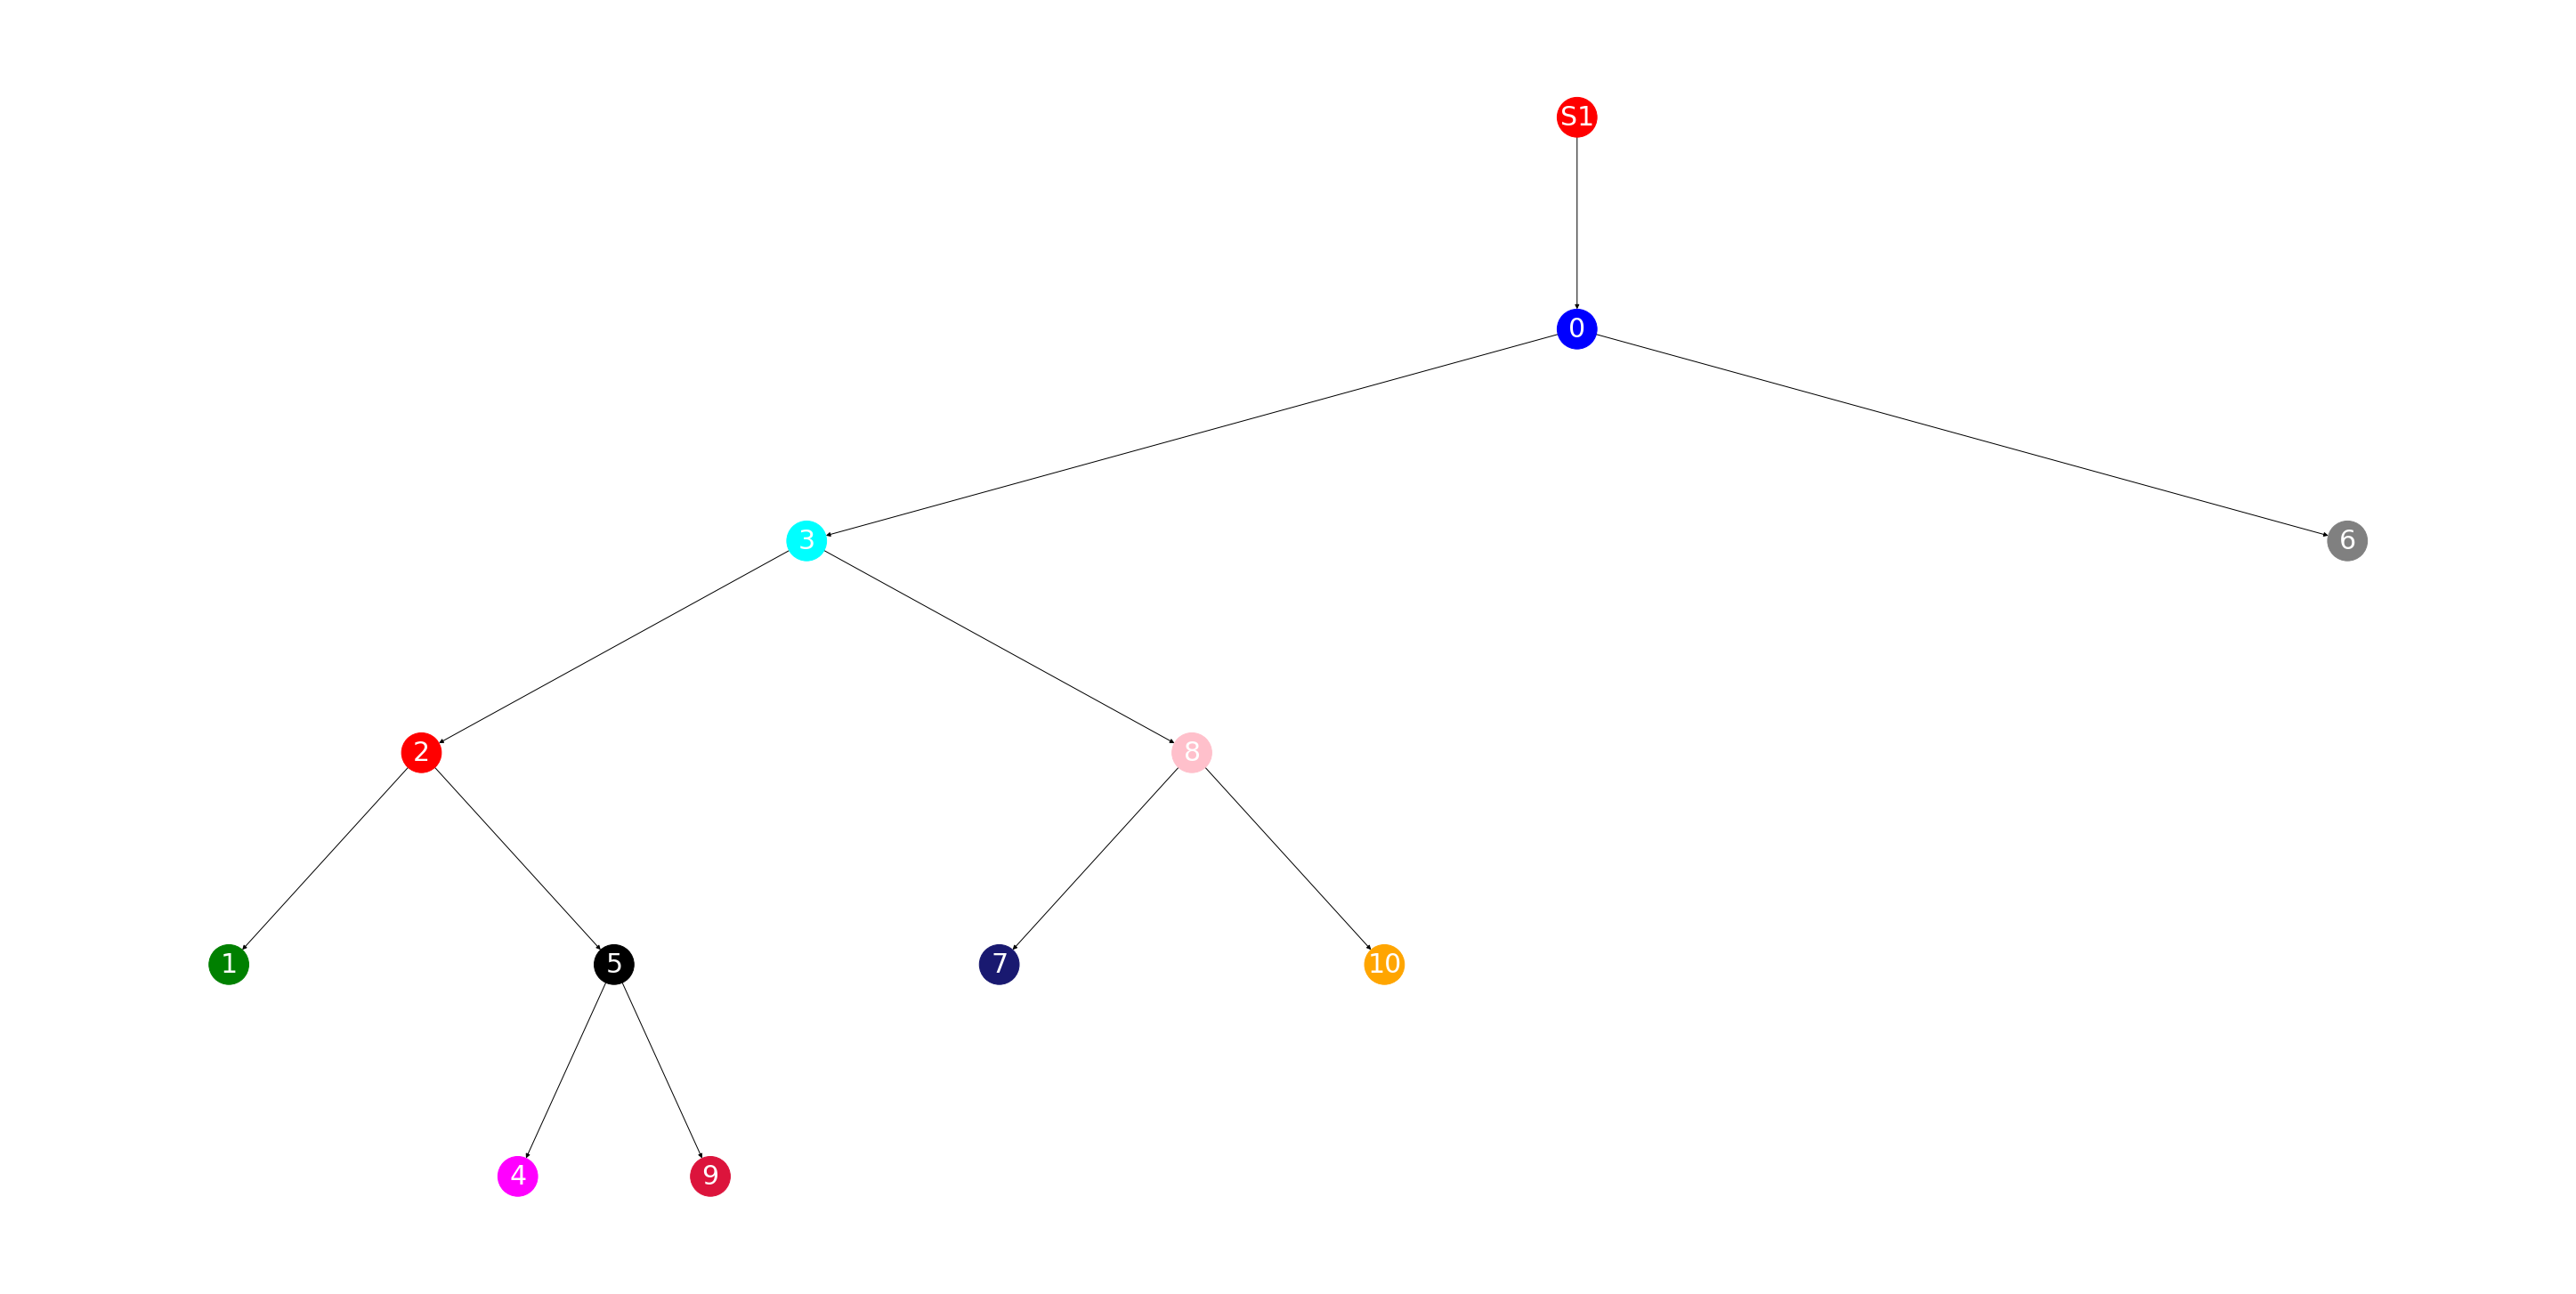

In [102]:
nviz.plot_limb_concept_network_2D(neuron_obj,
                                 ret_col)

# Sending the data to the Neuron Object

In [ ]:
nru = reload(nru)
save_time = time.time()
neuron_obj.save_compressed_neuron(output_folder="/notebooks/test_neurons/Fusion_decomp/",
                                 export_mesh=True,
                                 suppress_output=True)
print(f"Save time = {time.time() - save_time}")

In [ ]:
nru = reload(nru)
reload_time = time.time()
recovered_neuron = nru.decompress_neuron(filepath="./12345_double_soma",
                     original_mesh="./12345_double_soma")
print(f"Save time = {time.time() - reload_time}")

In [ ]:
import neuron_visualizations as nviz
returned_colors = nviz.visualize_neuron(recovered_neuron,
                     visualize_type=["mesh","skeleton"],
                     limb_branch_dict=dict(L6="all"),
                                       return_color_dict=True)